In [1]:
import warnings

# Suppress all warnings to keep the output clean (use with caution)
warnings.filterwarnings('ignore')

In [2]:
# Standard Library
import datetime
import math
import time

# Third-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-Learn
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Set the random seed for reproducibility (ensures consistent results across runs)
torch.manual_seed(29)

Data processing

top10_hourly.csv => dataset from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EGZHFV consisting of the top 10 grids for internet usage

In [4]:
# Load your dataset
file_path = 'top10_hourly.csv'
data = pd.read_csv(file_path)
# Check for missing values
missing_values = data.isnull().sum()
data.head(), missing_values, data.shape

(   gridID            startTime       smsIn      smsOut     callIn    callOut  \
 0    4855  2013-11-01 00:00:00  162.544860  108.047183  86.442554  73.567003   
 1    4855  2013-11-01 01:00:00   70.501121   49.862977  32.884867  32.880394   
 2    4855  2013-11-01 02:00:00   70.783845   58.709391  28.995517  20.332120   
 3    4855  2013-11-01 03:00:00   88.376602   42.572260  10.881794  17.571800   
 4    4855  2013-11-01 04:00:00   31.449764   13.513663  18.121553  12.697979   
 
       internet  
 0  4889.373920  
 1  3699.700209  
 2  2826.055092  
 3  2704.410485  
 4  2736.943809  ,
 gridID       0
 startTime    0
 smsIn        0
 smsOut       0
 callIn       0
 callOut      0
 internet     0
 dtype: int64,
 (14880, 7))

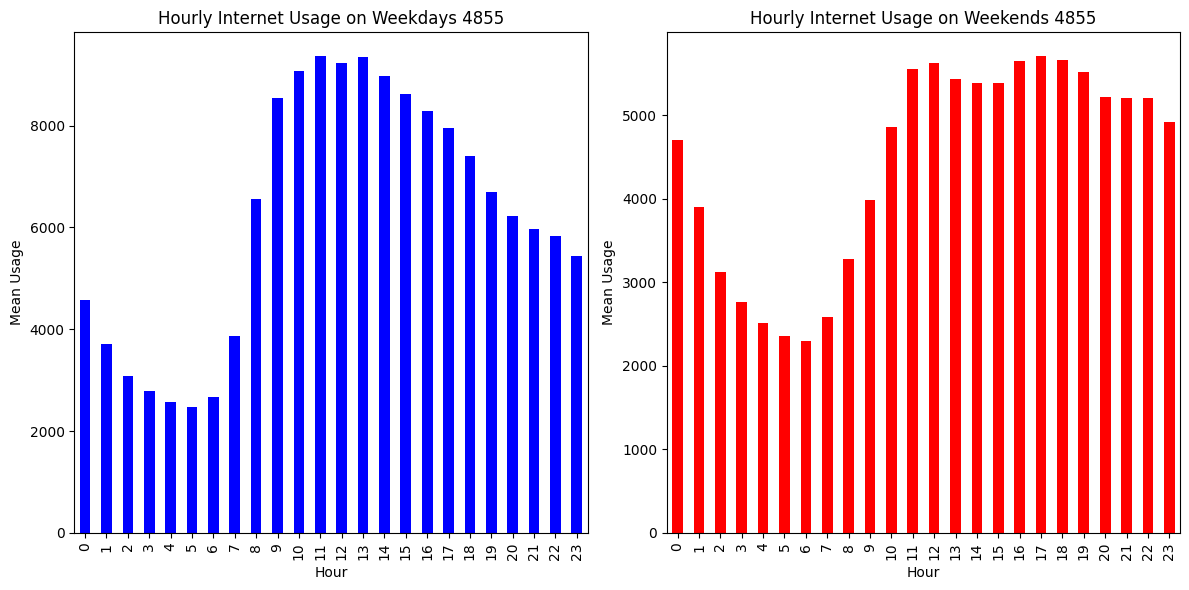

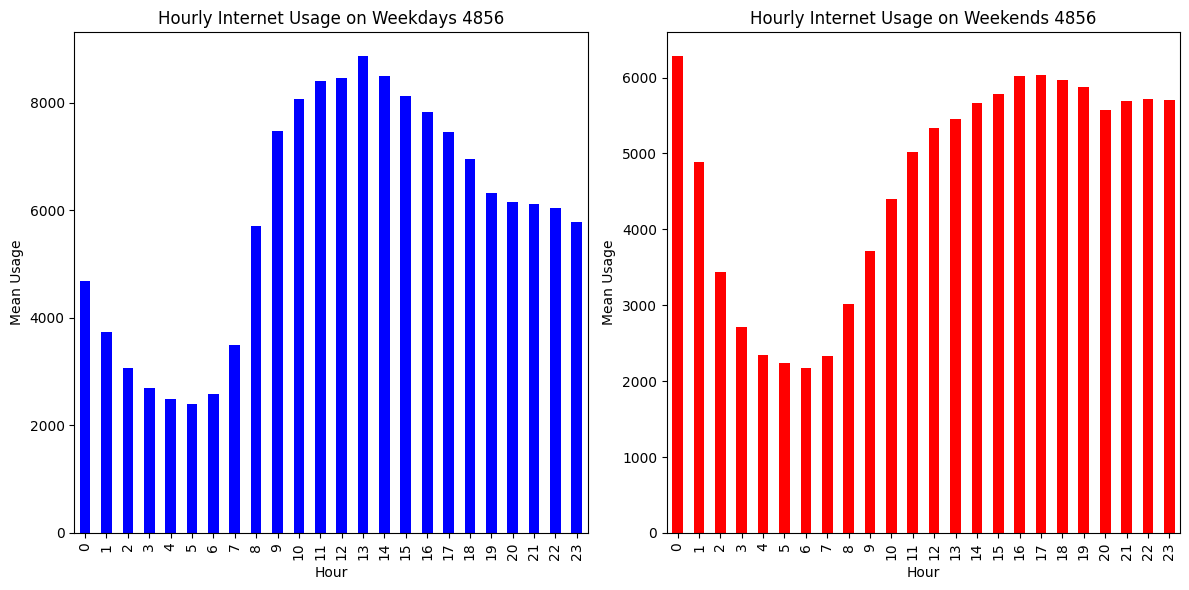

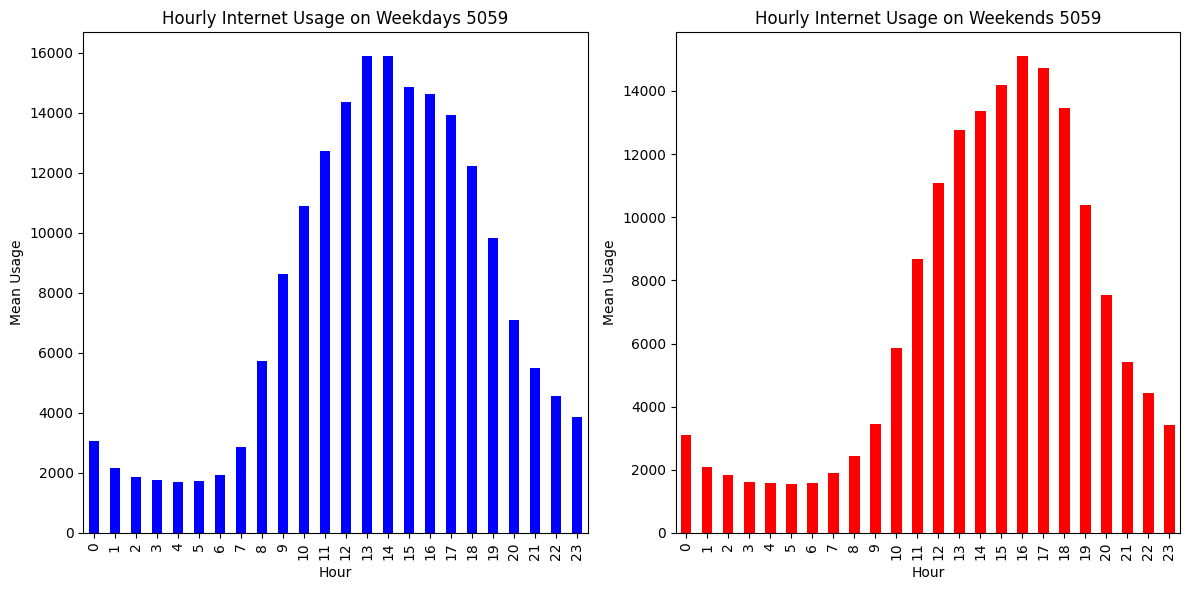

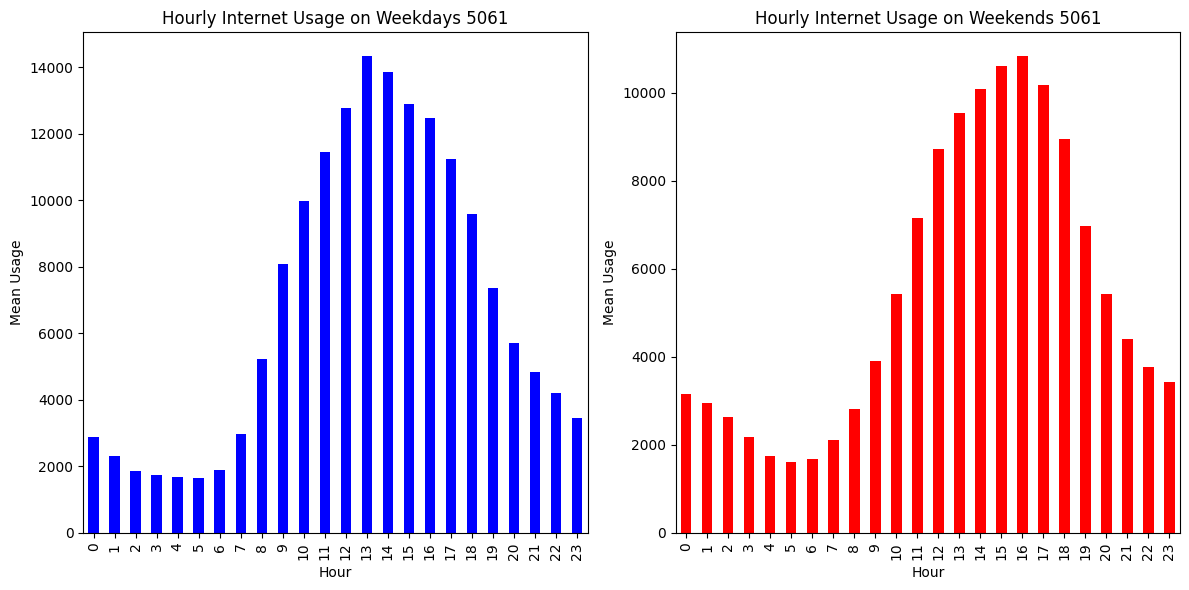

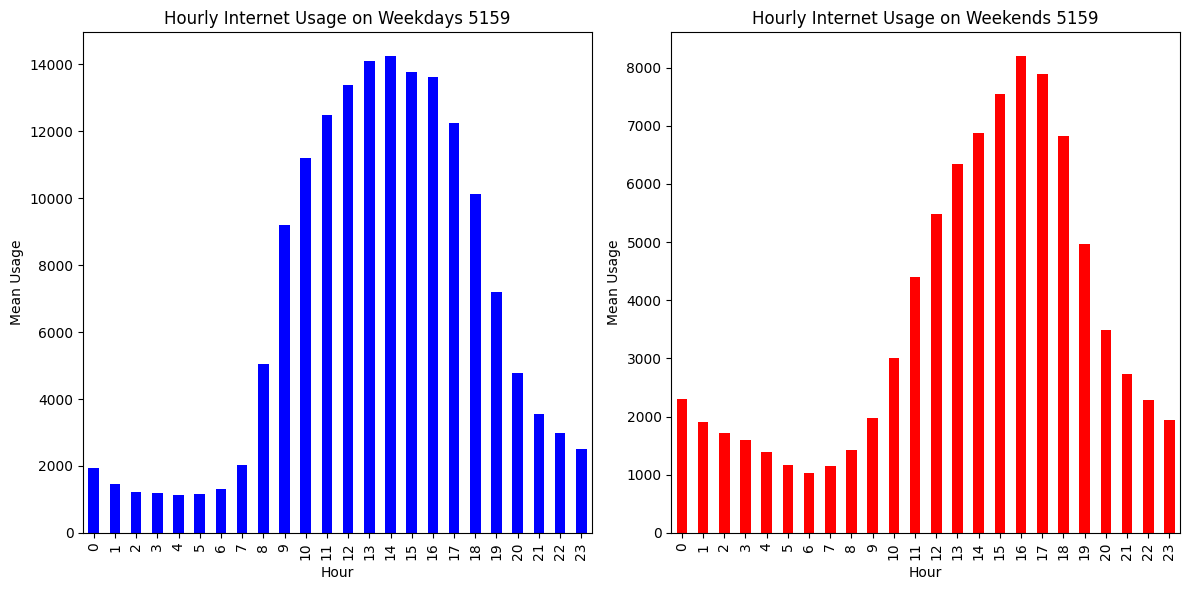

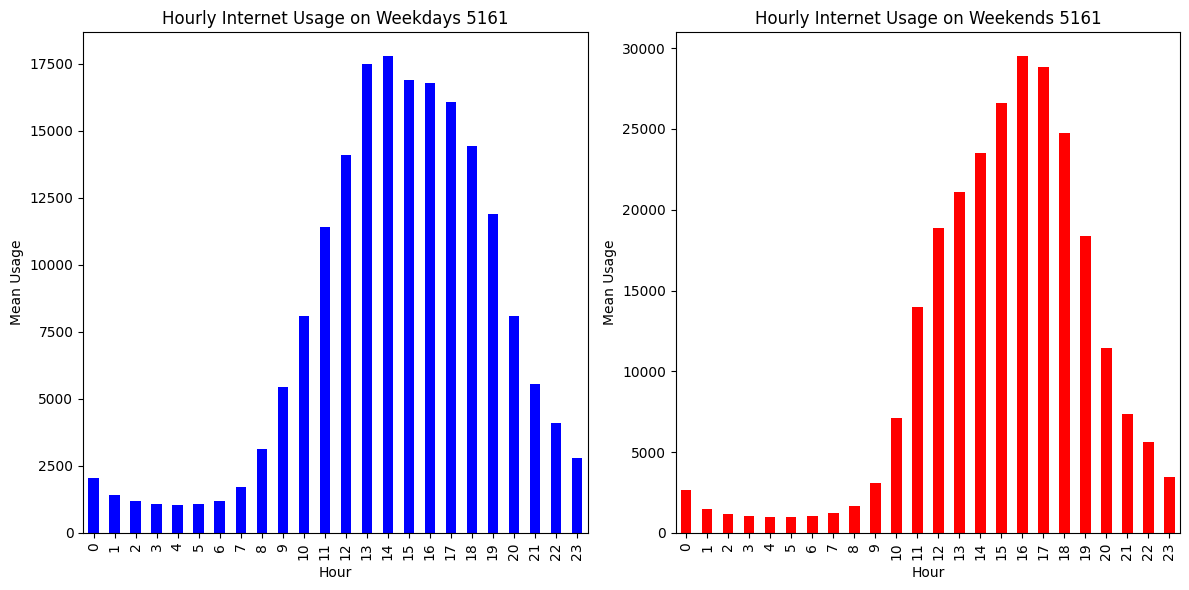

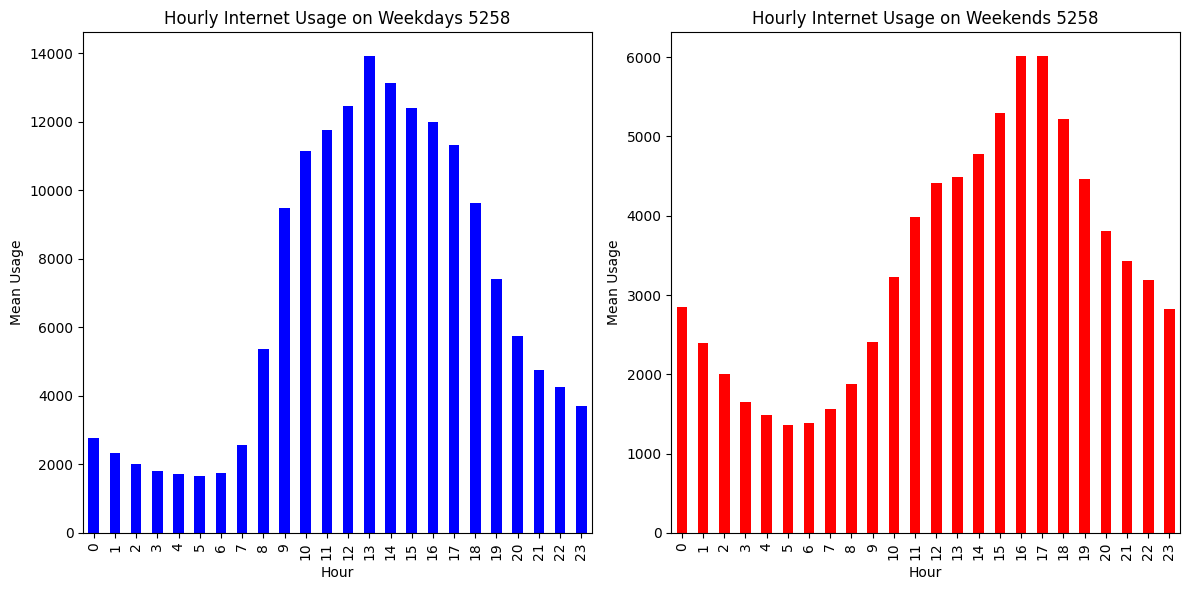

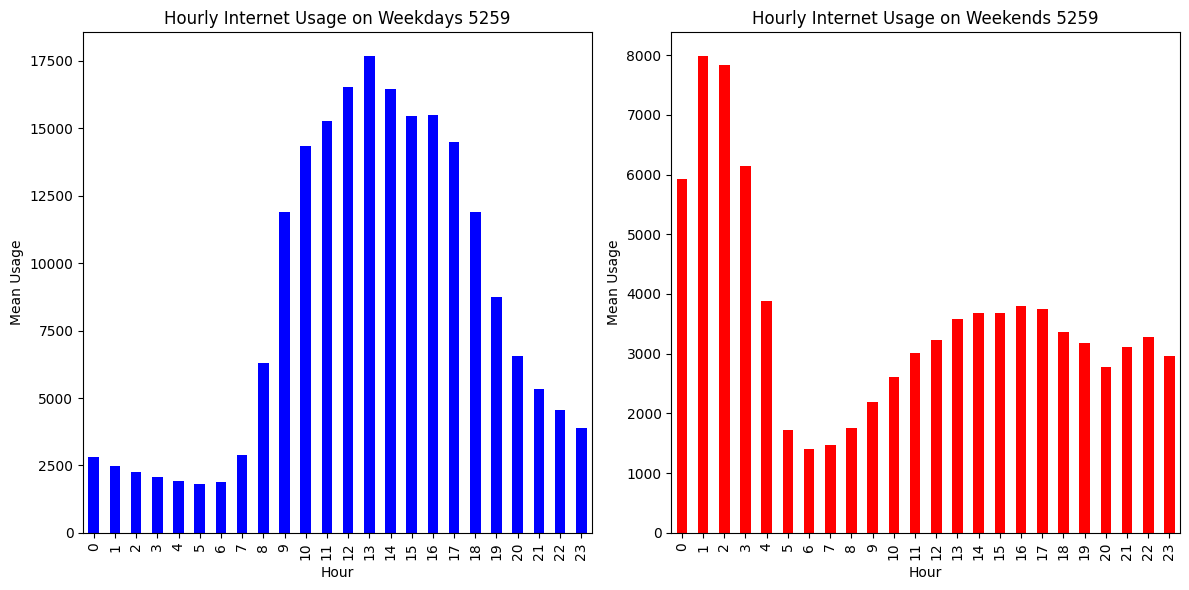

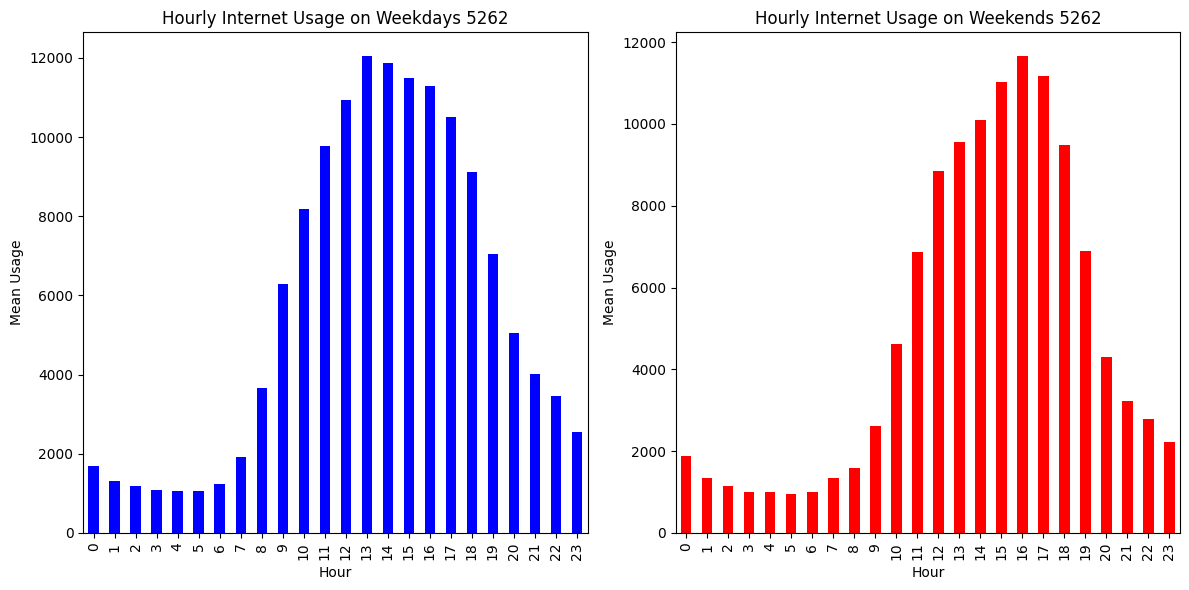

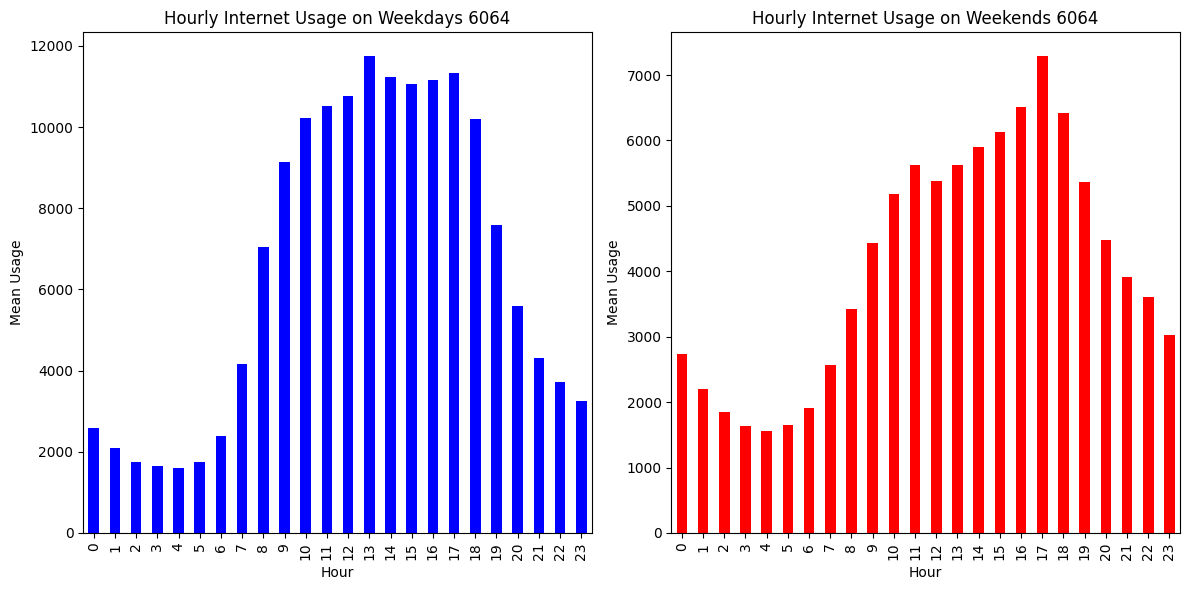

In [5]:
#Mean hourly distribution weekday/weekend for the internet feature
data_internet = data.drop(columns = ['smsIn', 'smsOut','callIn', 'callOut'])

data_internet.set_index('startTime', inplace=True)
for grid in data_internet.gridID.unique():

    data_grid = data_internet[data_internet['gridID'] == grid]
    data_grid.index = pd.to_datetime(data_grid.index)
    # Create a new column 'Weekday' to categorize weekdays and weekends
    data_grid['Weekday'] = data_grid.index.weekday < 5  # True for weekdays, False for weekends
    # Calculate statistics for weekdays and weekends
    #weekday_stats = data_grid[data_grid['Weekday']].describe()
    #weekend_stats = data_grid[~data_grid['Weekday']].describe()

    data_grid['Hour'] = data_grid.index.hour

    # Group the data by hour and weekday/weekend, and calculate the mean usage
    hourly_usage = data_grid.groupby(['Hour', 'Weekday'])['internet'].mean().unstack()

    # Plot the histograms
    plt.figure(figsize=(12, 6))

    # Plot the histogram for weekdays
    plt.subplot(1, 2, 1)
    hourly_usage[True].plot(kind='bar', color='blue')
    plt.title(f'Hourly Internet Usage on Weekdays {grid}')
    plt.xlabel('Hour')
    plt.ylabel('Mean Usage')

    # Plot the histogram for weekends
    plt.subplot(1, 2, 2)
    hourly_usage[False].plot(kind='bar', color='red')
    plt.title(f'Hourly Internet Usage on Weekends {grid}')
    plt.xlabel('Hour')
    plt.ylabel('Mean Usage')

    plt.tight_layout()
    plt.show()

In [6]:
# Define a set of six specific grid IDs to filter the dataset
six_grids = (5059, 5159, 5262, 5061, 5259, 6064)
# Create a boolean mask to filter rows where 'gridID' is in the defined set
mask = data['gridID'].isin(six_grids)
# Apply the mask to keep only the rows with the selected grid IDs
data = data[mask]

In [7]:
data.head(), data.tail()

(      gridID            startTime       smsIn      smsOut     callIn  \
 2976    5059  2013-11-01 00:00:00  177.102719  149.554856  92.687108   
 2977    5059  2013-11-01 01:00:00  101.345768  159.323853  38.493504   
 2978    5059  2013-11-01 02:00:00   56.312823  106.536970  31.904731   
 2979    5059  2013-11-01 03:00:00   96.496178  102.286239  28.394988   
 2980    5059  2013-11-01 04:00:00   94.968230  130.207161  14.962744   
 
          callOut     internet  
 2976  113.072191  3549.351436  
 2977   56.650364  2511.210825  
 2978   60.508954  2180.798190  
 2979  104.482368  1857.653625  
 2980   36.634123  2211.357051  ,
        gridID            startTime       smsIn      smsOut      callIn  \
 14875    6064  2014-01-01 19:00:00  496.792765  209.878601  237.998348   
 14876    6064  2014-01-01 20:00:00  327.928821  208.800388  180.016671   
 14877    6064  2014-01-01 21:00:00  228.143594   98.821092  152.324751   
 14878    6064  2014-01-01 22:00:00  224.719325  174.944977  

In [8]:
# Convert startTime to datetime
data['startTime'] = pd.to_datetime(data['startTime'])
# Filter the data to keep only records on or before 2013-12-22
filtered_data = data[data['startTime'] <= '2013-12-22']
filtered_data.tail()

gridID           startTime       smsIn      smsOut      callIn  \
14612    6064 2013-12-21 20:00:00  402.716159  169.088563  290.953989   
14613    6064 2013-12-21 21:00:00  279.963939  121.014590  181.774419   
14614    6064 2013-12-21 22:00:00  314.778213  116.812276  132.910724   
14615    6064 2013-12-21 23:00:00  201.084586  143.489276   91.638965   
14616    6064 2013-12-22 00:00:00   97.498804   60.973281   56.722152   

          callOut     internet  
14612  382.715295  4420.744152  
14613  204.392880  3919.924584  
14614  167.114616  3706.461627  
14615  105.453760  3030.986434  
14616   71.812944  2670.088054

In [9]:
# Create anomaly marker columns for relevant features
#At first all samples are normal, marked with 0
filtered_data['anomaly'] = 0
filtered_data.head()

gridID           startTime       smsIn      smsOut     callIn  \
2976    5059 2013-11-01 00:00:00  177.102719  149.554856  92.687108   
2977    5059 2013-11-01 01:00:00  101.345768  159.323853  38.493504   
2978    5059 2013-11-01 02:00:00   56.312823  106.536970  31.904731   
2979    5059 2013-11-01 03:00:00   96.496178  102.286239  28.394988   
2980    5059 2013-11-01 04:00:00   94.968230  130.207161  14.962744   

         callOut     internet  anomaly  
2976  113.072191  3549.351436        0  
2977   56.650364  2511.210825        0  
2978   60.508954  2180.798190        0  
2979  104.482368  1857.653625        0  
2980   36.634123  2211.357051        0

In [10]:
# Splitting the dataset to train (80%) and test (20%)
# Sorting the data by 'startTime' to ensure the chronological order is maintained.

sorted_data = filtered_data.sort_values(by='startTime')

# Calculate the index for the 80/20 split
split_index = int(len(sorted_data) * 0.8)

# Split the data into train and test sets
train_data = sorted_data.iloc[:split_index]
test_data = sorted_data.iloc[split_index:]
train_data.tail()

gridID           startTime        smsIn      smsOut      callIn  \
6931     5159 2013-12-11 19:00:00   794.475382  394.006934  525.853792   
3955     5059 2013-12-11 19:00:00  1279.520793  465.071852  822.431140   
5443     5061 2013-12-11 19:00:00   845.142526  344.685229  527.975005   
11395    5259 2013-12-11 19:00:00   657.129062  304.360843  574.689735   
14371    6064 2013-12-11 19:00:00   925.376774  335.628933  553.732614   

          callOut      internet  anomaly  
6931   691.608473   9233.978062        0  
3955   995.244108  12131.191935        0  
5443   676.436330   8936.997525        0  
11395  622.545265  11521.013966        0  
14371  827.919130   8279.312020        0

In [11]:
# Anomaly Injection: Introduce synthetic anomalies into test_data

for grid in test_data['gridID'].unique():
    # Introduce an anomaly on December 17, 2013 (10 AM - 8 PM)
    # - A significant drop (90% decrease) in SMS In for all grids
    # - Label the anomaly as type 2 (SMS-related anomaly)
    anomaly_mask_1 = (test_data['gridID'] == grid) & (test_data['startTime'].dt.date == datetime.datetime(2013, 12, 18).date()) \
                     & (test_data['startTime'].dt.hour >= 10) & (test_data['startTime'].dt.hour <= 20)
    test_data.loc[anomaly_mask_1, 'smsIn'] *= 0.1  # Drop in SMS In
    test_data.loc[anomaly_mask_1, 'anomaly'] = 2  # Mark as SMS anomaly

    # Introduce an anomaly on December 16, 2013 (10 AM - 8 PM)
    # - A significant drop (90% decrease) in Call Out for all grids
    # - Label the anomaly as type 3 (Call Out-related anomaly)
    anomaly_mask_2 = (test_data['gridID'] == grid) & (test_data['startTime'].dt.date == datetime.datetime(2013, 12, 16).date()) \
                     & (test_data['startTime'].dt.hour >= 10) & (test_data['startTime'].dt.hour <= 20)
    test_data.loc[anomaly_mask_2, 'callOut'] *= 0.1  # Drop in Call Out
    test_data.loc[anomaly_mask_2, 'anomaly'] = 3  # Mark as Call Out anomaly

# Introduce a different type of anomaly for grid 5059 on December 14, 2013 (10 AM - 8 PM)
# - A sharp increase (2.5x spike) in internet usage
# - Label the anomaly as type 1 (Internet usage anomaly)
anomaly_mask = (test_data['gridID'] == 5059) & (test_data['startTime'].dt.date == datetime.datetime(2013, 12, 14).date()) \
               & (test_data['startTime'].dt.hour >= 10) & (test_data['startTime'].dt.hour <= 20)
test_data.loc[anomaly_mask, 'internet'] *= 2.5  # Spike in internet usage
test_data.loc[anomaly_mask, 'anomaly'] = 1  # Mark as Internet anomaly

In [12]:
#save test dataset to CSV files
test_file_path = 'test_dataset_abnormal.csv'
test_data.to_csv(test_file_path, index=False)

In [13]:
# Set the startTime as the index
train_data.set_index('startTime', inplace=True)
test_data.set_index('startTime', inplace=True)

In [14]:
# Create time-based features to capture temporal patterns in the data

# Extract hour of the day (0-23) to capture daily trends
train_data['hour'] = train_data.index.hour
test_data['hour'] = test_data.index.hour

# Extract day of the week (0 = Monday, 6 = Sunday) to capture weekly patterns
train_data['day_of_week'] = train_data.index.dayofweek
test_data['day_of_week'] = test_data.index.dayofweek

# Extract day of the month (1-31) to capture potential monthly trends
train_data['day_of_month'] = train_data.index.day
test_data['day_of_month'] = test_data.index.day

# Extract month (1-12) to account for seasonal variations
train_data['month'] = train_data.index.month
test_data['month'] = test_data.index.month

In [15]:
# Preserve the original gridID and timestamps for anomaly visualization
train_grid_ids = train_data['gridID'].values
test_grid_ids = test_data['gridID'].values
train_timestamps = train_data.index
test_timestamps = test_data.index

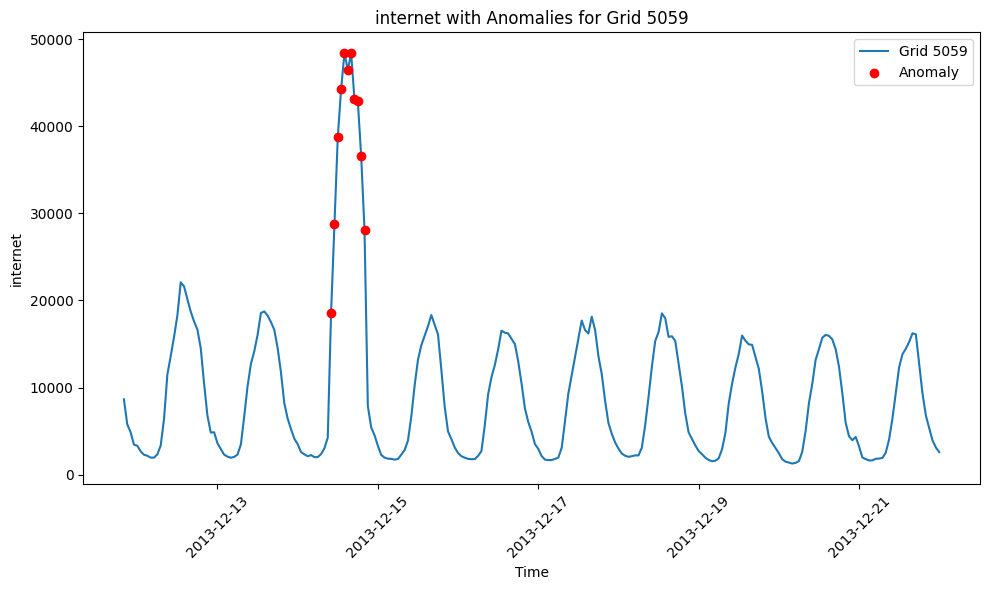

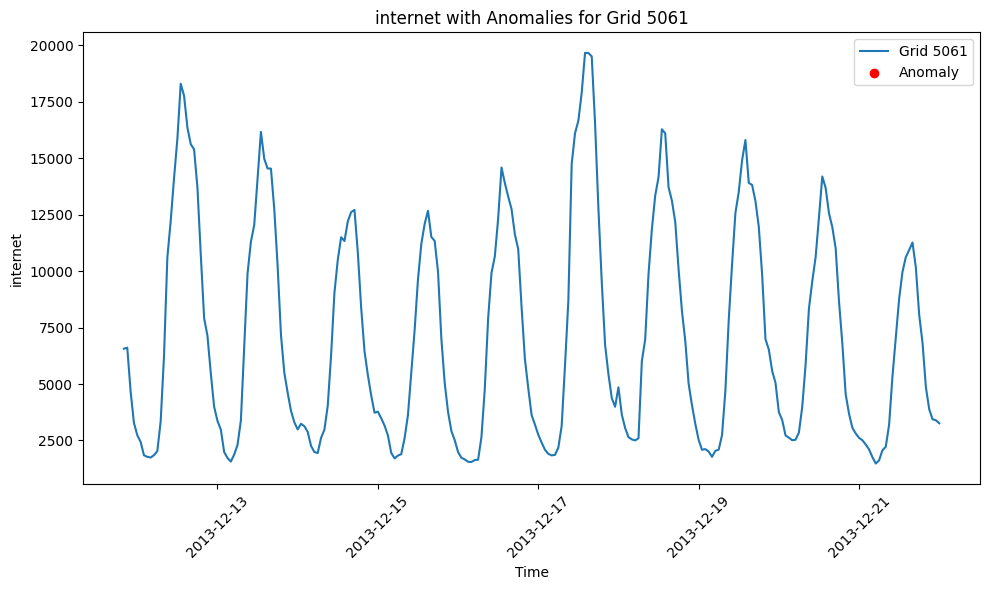

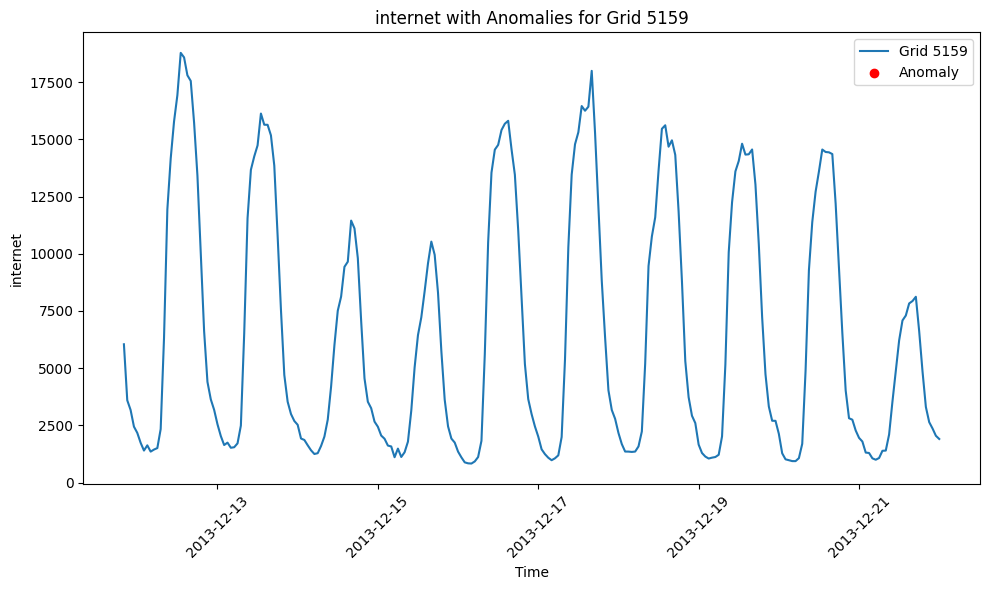

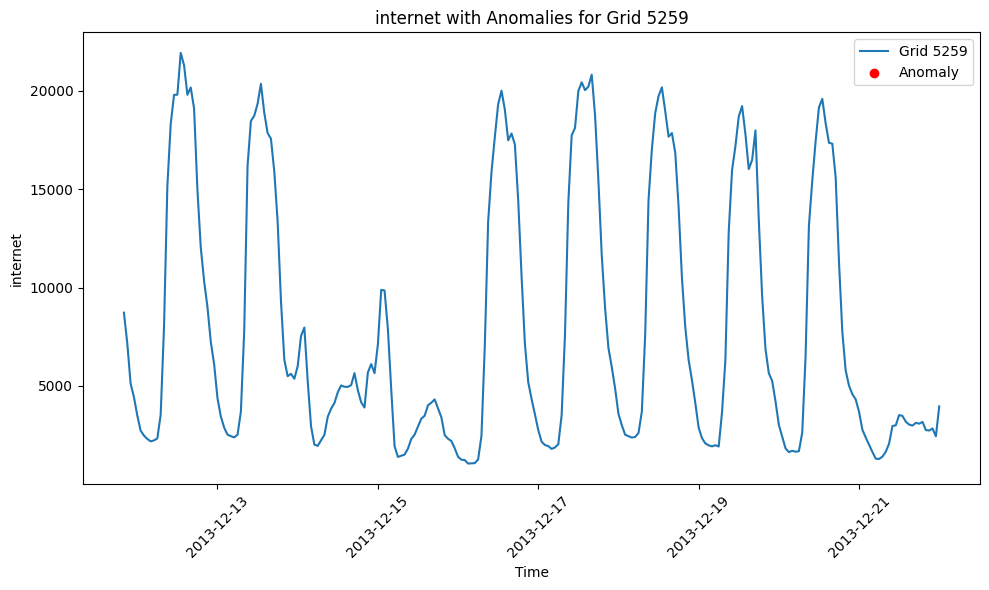

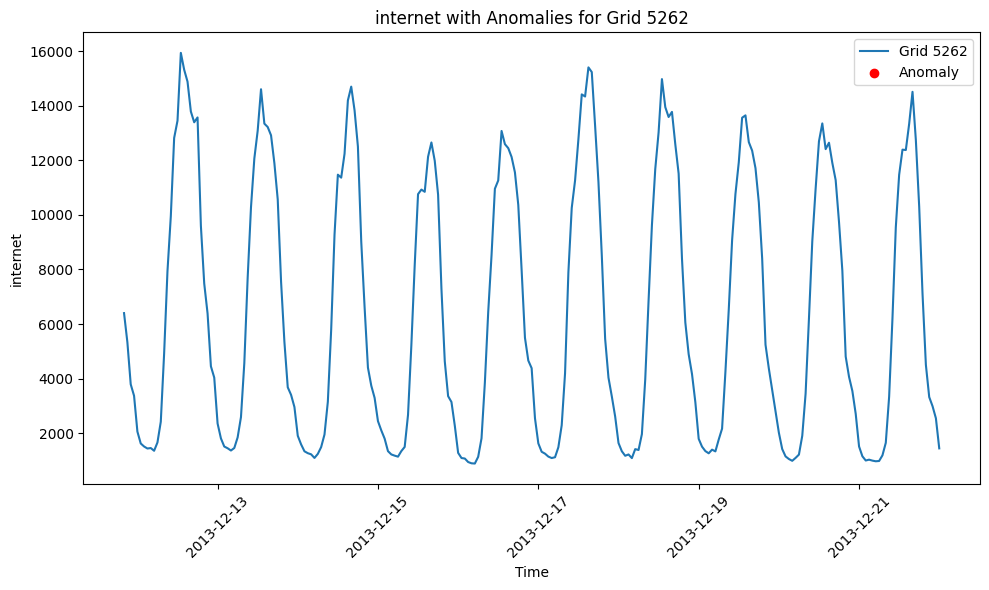

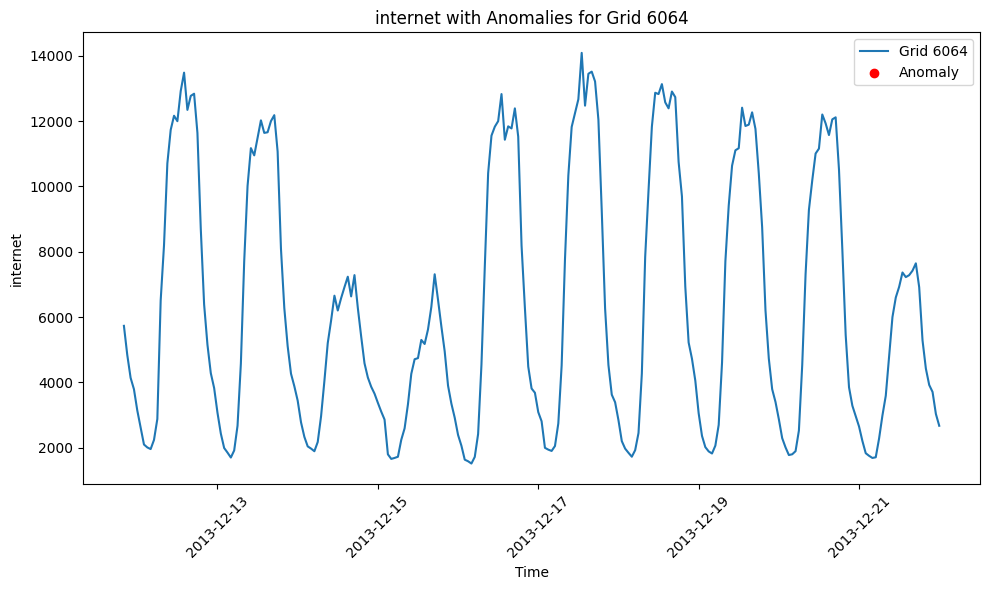

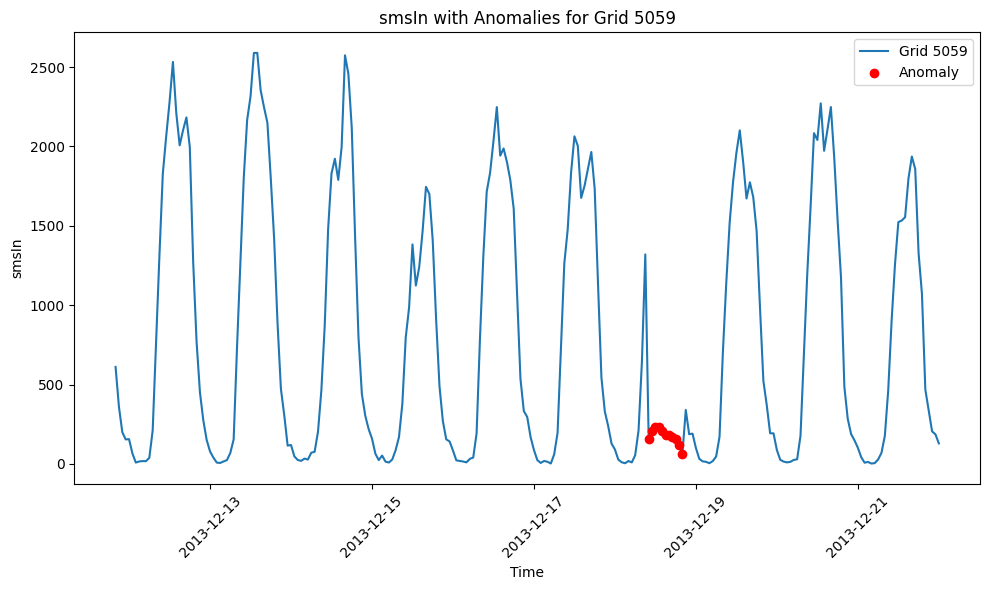

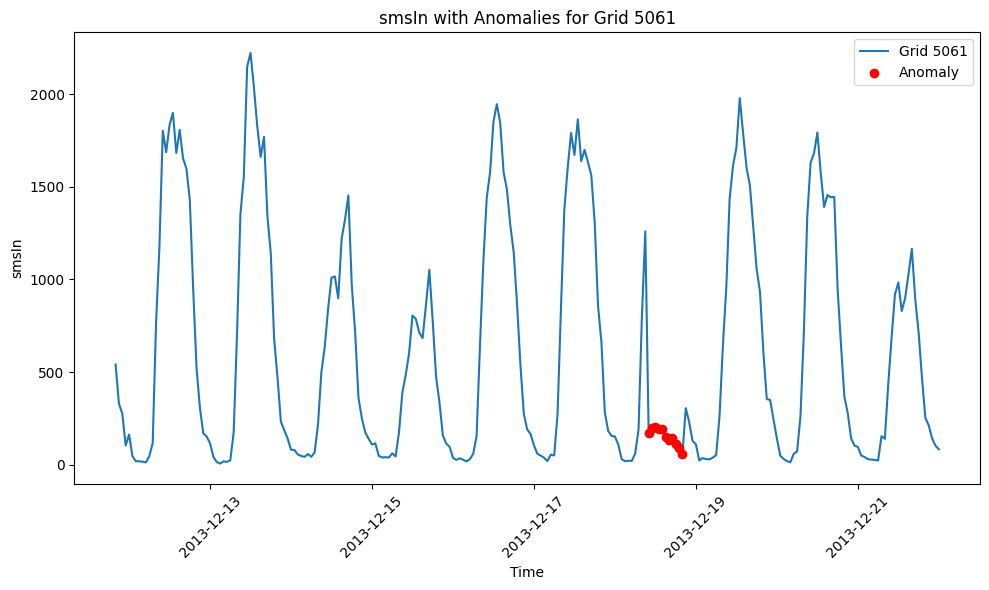

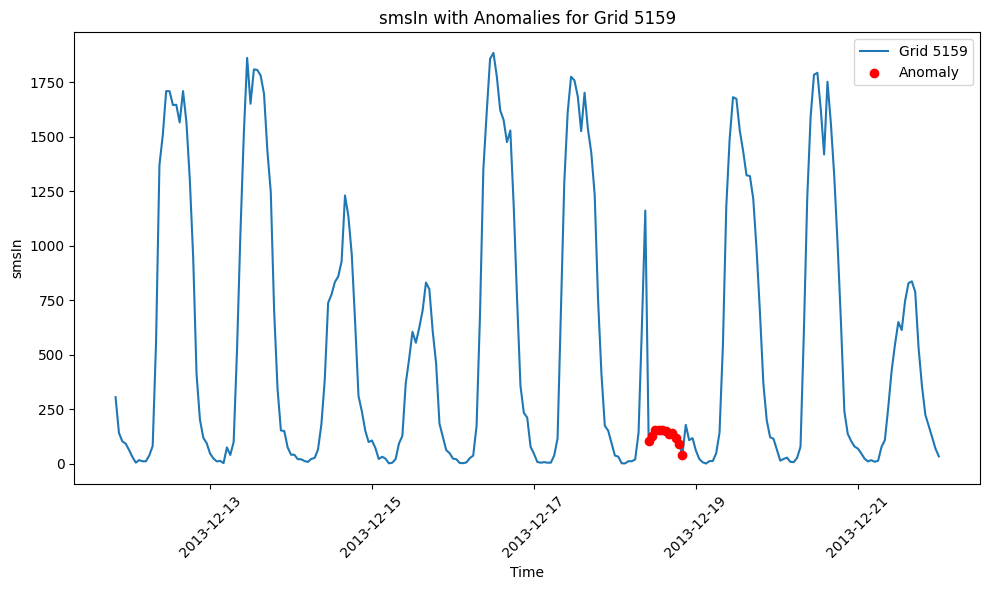

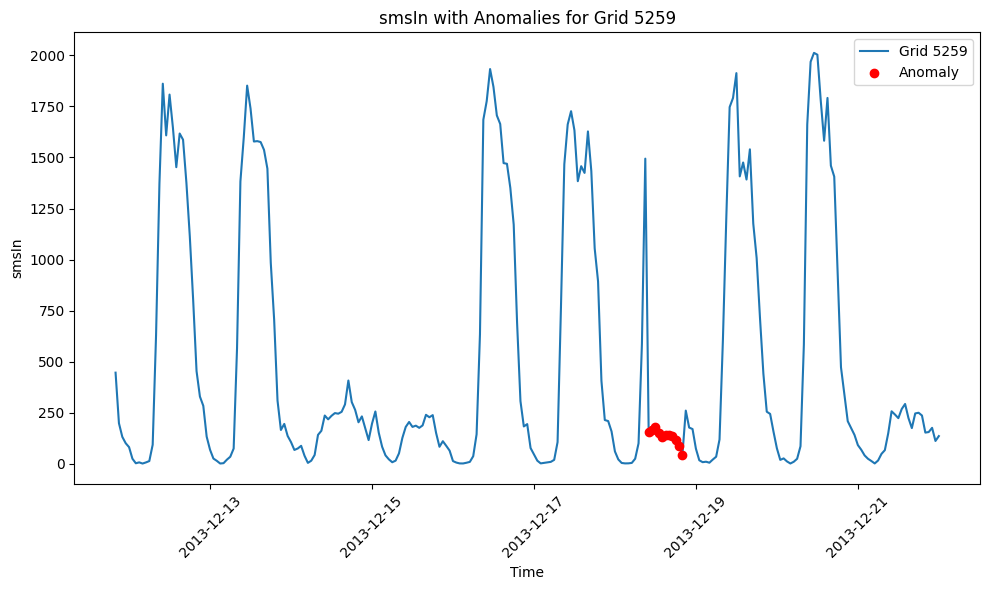

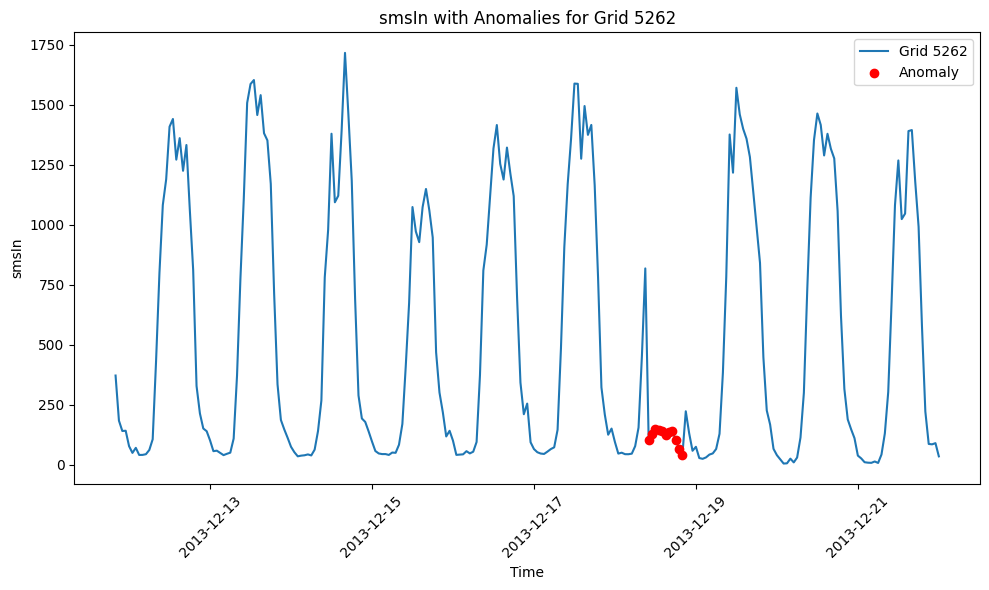

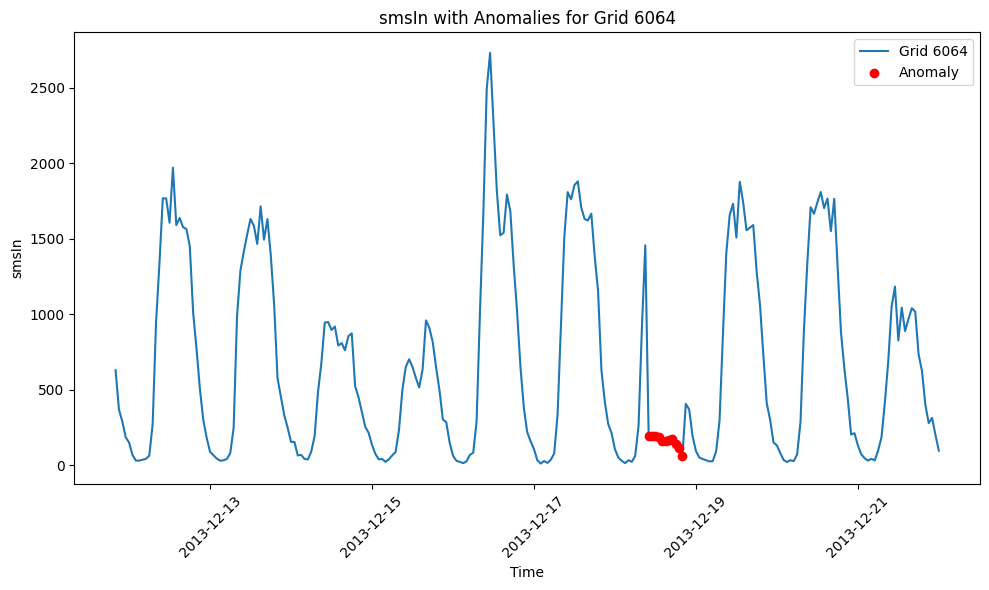

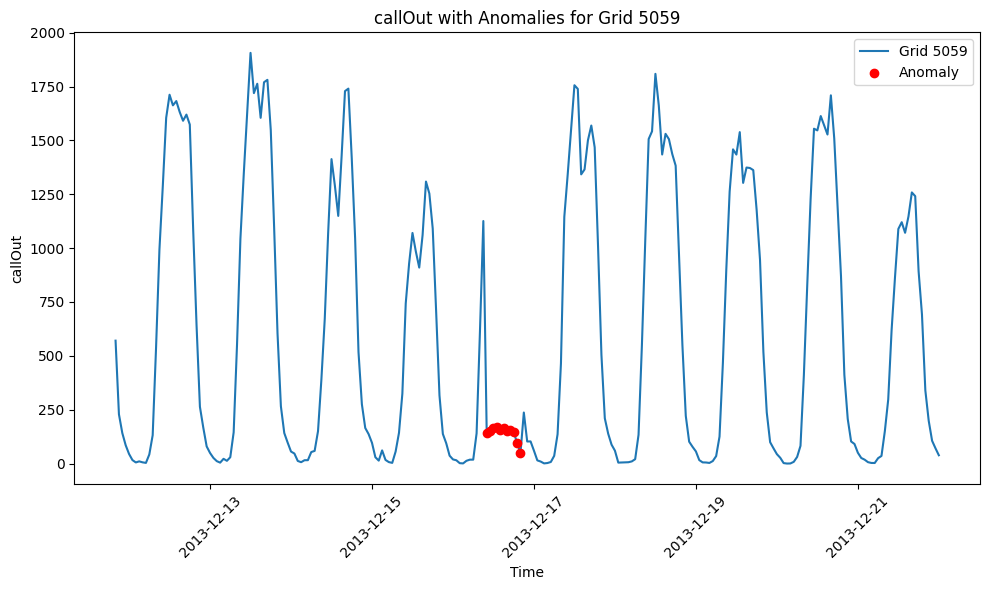

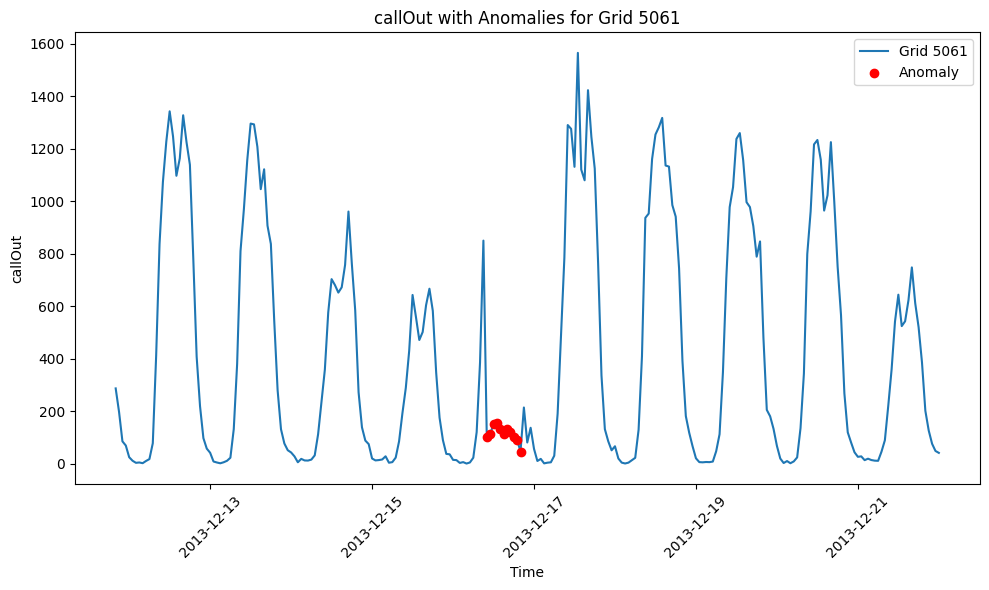

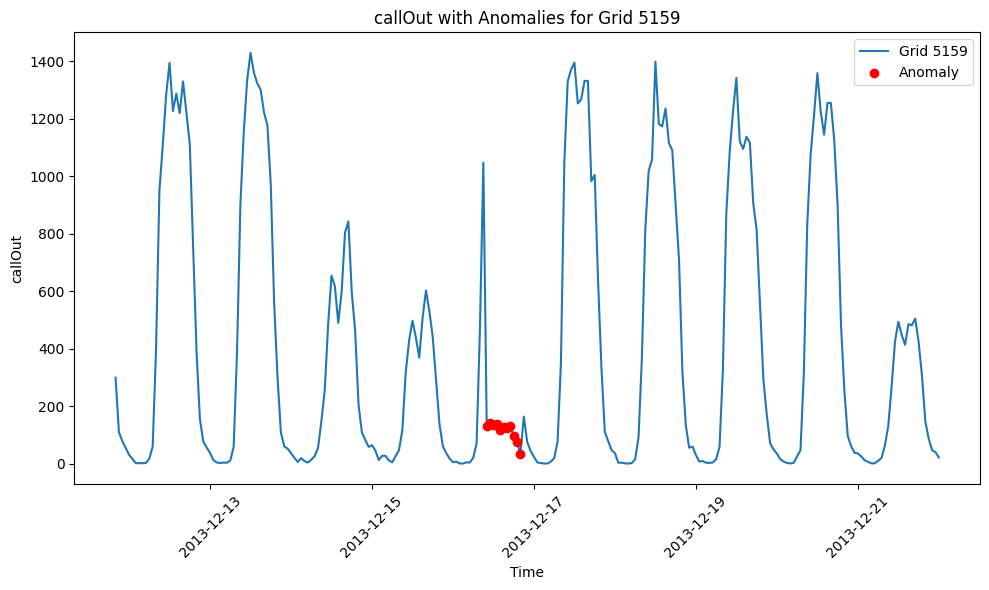

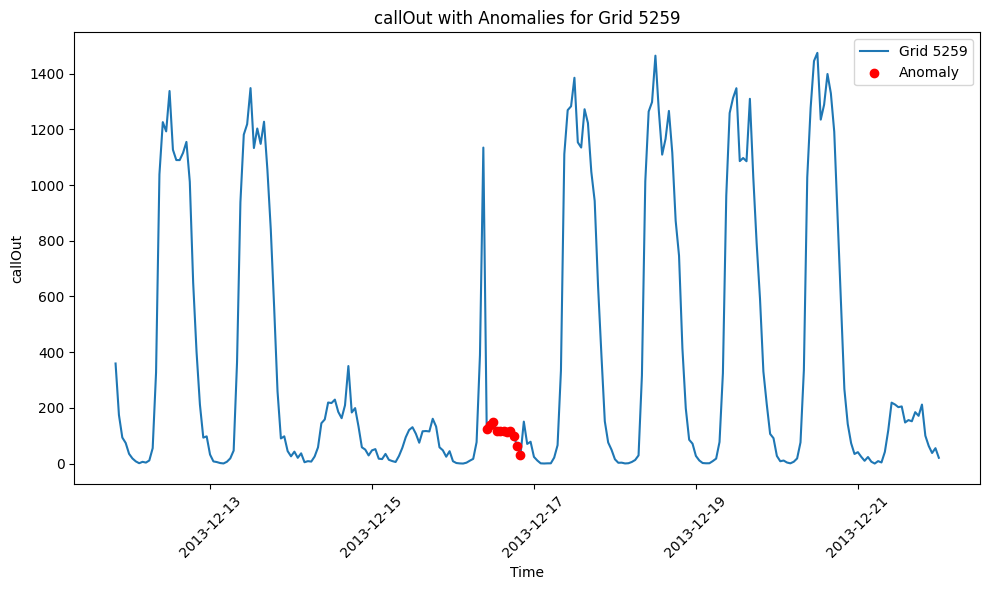

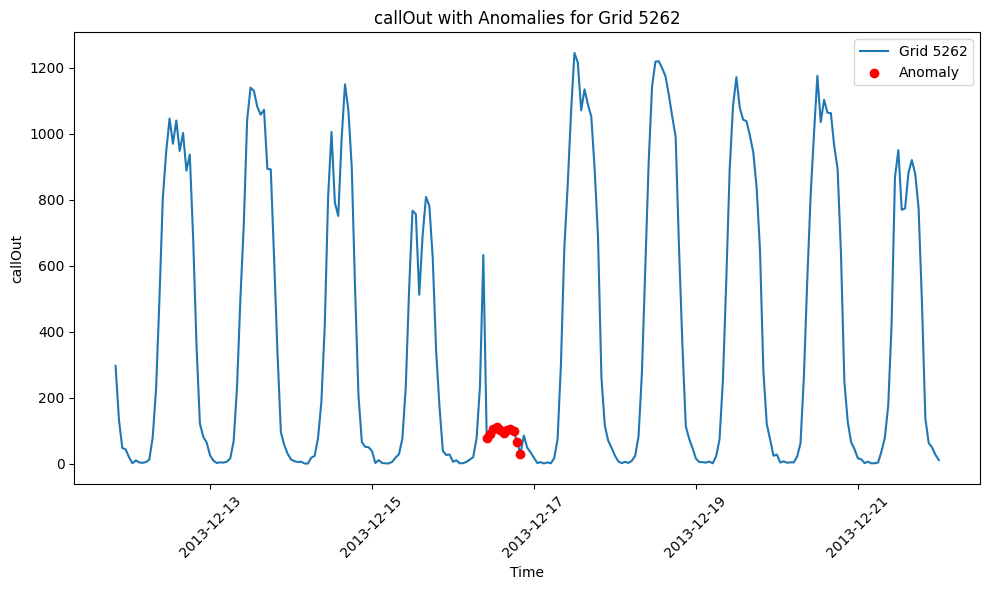

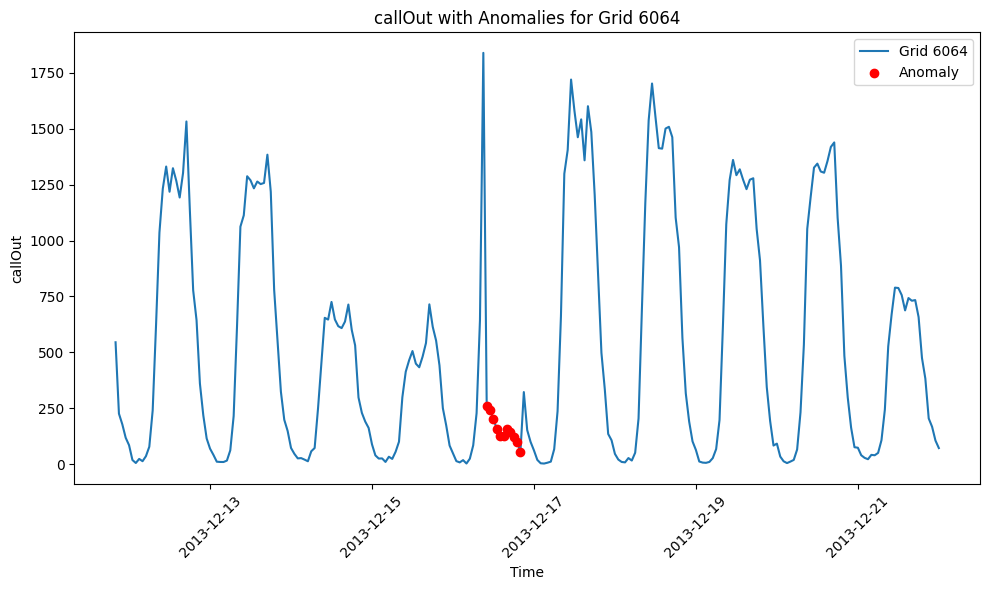

In [16]:
# Function to plot each feature for every grid and mark anomalies
def plot_each_feature_with_combined_anomalies(feature, anomaly_value):
    grid_ids = np.unique(test_grid_ids)
    for grid_id in grid_ids:
        grid_data = test_data[test_data['gridID'] == grid_id]

        # Plot the normal feature data
        plt.figure(figsize=(10, 6))
        plt.plot(grid_data.index, grid_data[feature], label=f'Grid {grid_id}')

        # Mark anomalies with red dots based on the merged anomaly column
        anomaly_data = grid_data[grid_data['anomaly'] == anomaly_value]
        plt.scatter(anomaly_data.index, anomaly_data[feature], color='red', label='Anomaly', zorder=5)

        # Add labels and title
        plt.title(f'{feature} with Anomalies for Grid {grid_id}')
        plt.xlabel('Time')
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot for Internet usage with anomalies (anomaly value 1)
plot_each_feature_with_combined_anomalies('internet', 1)

# Plot for SMS In with anomalies (anomaly value 2)
plot_each_feature_with_combined_anomalies('smsIn', 2)

# Plot for Call Out with anomalies (anomaly value 3)
plot_each_feature_with_combined_anomalies('callOut', 3)

In [17]:
# Normalize/Standardize the data to improve model performance and stability
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
# Apply the same transformation to the test data (without fitting again to prevent data leakage)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

In [18]:
# Drop gridID  and anomaly from the features for training and testing
train_data = train_data.drop(columns=['gridID'])
train_data = train_data.drop(columns=['anomaly'])
test_data = test_data.drop(columns=['gridID'])
test_data = test_data.drop(columns=['anomaly'])
train_data.head(), test_data.head()

(               smsIn    smsOut    callIn   callOut  internet     hour  \
 startTime                                                               
 2013-11-01 -0.702348 -0.501005 -0.676984 -0.680236 -0.639601 -1.65923   
 2013-11-01 -0.818409 -0.849940 -0.730269 -0.762272 -0.825026 -1.65923   
 2013-11-01 -0.684240 -0.693950 -0.714756 -0.823129 -0.223626 -1.65923   
 2013-11-01 -0.850232 -0.721293 -0.829521 -0.877435 -0.727719 -1.65923   
 2013-11-01 -0.833461 -0.893729 -0.778193 -0.818453 -0.696028 -1.65923   
 
             day_of_week  day_of_month     month  
 startTime                                        
 2013-11-01     0.491239      -1.37627 -0.600925  
 2013-11-01     0.491239      -1.37627 -0.600925  
 2013-11-01     0.491239      -1.37627 -0.600925  
 2013-11-01     0.491239      -1.37627 -0.600925  
 2013-11-01     0.491239      -1.37627 -0.600925  ,
                         smsIn    smsOut    callIn   callOut  internet  \
 startTime                                      

In [19]:
# Convert the training and testing data to PyTorch tensors
train_tensor = torch.tensor(train_data.values, dtype=torch.float32)
test_tensor = torch.tensor(test_data.values, dtype=torch.float32)

# For time series data, split chronologically
# Use the last 20% of training data for validation
val_split_idx = int(0.8 * len(train_tensor))

# Split training tensor chronologically
train_subset_tensor = train_tensor[:val_split_idx]
val_subset_tensor = train_tensor[val_split_idx:]

# Create datasets
train_subset = TensorDataset(train_subset_tensor, train_subset_tensor)
val_subset = TensorDataset(val_subset_tensor, val_subset_tensor)
test_dataset = TensorDataset(test_tensor, test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)  # No shuffle for time series
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
train_tensor.shape, test_tensor.shape

(torch.Size([5880, 9]), torch.Size([1470, 9]))

Transformer model

In [21]:
class MultiHeadAttention(nn.Module):
    """
    A simplified multi-head attention from scratch.
    This is supposed tp mimic nn.MultiheadAttention with:
      - queries, keys, values all of dimension d_model
      - number of heads = nhead
    """
    def __init__(self, d_model, nhead, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        if d_model % nhead != 0: # Check if total embedding dimension is divisible by the number of heads so each head has an integer dimension (d_k)
            raise ValueError("d_model must be divisible by nhead")

        self.d_model = d_model
        self.nhead = nhead
        self.d_k = d_model // nhead # Calculating the dimension of each head

        # Learnable linear transformations for Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        # Final output linear transformation
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        """
        query, key, value: (N, E)
          N = batch size
          E = embedding dimension (d_model)
        """
        # 1) Project inputs to Q, K, V
        Q = self.w_q(query)  # (N, d_model)
        K = self.w_k(key)    # (N, d_model)
        V = self.w_v(value)  # (N, d_model)

        # 2) Reshape to (N, nhead, d_k) for multi-head
        N, _ = Q.size() # Get the batch size (N) and embedding dimension (d_model)

        Q = Q.view(N, self.nhead, self.d_k)  # (N, nhead, d_k)
        K = K.view(N, self.nhead, self.d_k)  # (N, nhead, d_k)
        V = V.view(N, self.nhead, self.d_k)  # (N, nhead, d_k)

        # 3) Scaled dot-product attention
        #    QK^T shape => (N, nhead, d_k) x (N, nhead, d_k).T => (N, nhead, nhead)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (N, nhead, nhead)

        attn_weights = torch.softmax(scores, dim=-1)  # (N, nhead, nhead)
        attn_weights = self.dropout(attn_weights)

        # 4) Weighted sum of V
        out = torch.matmul(attn_weights, V)  # (N, nhead, d_k)

        # 5) Reshape back to (N, d_model)
        out = out.view(N, self.d_model)      # (N, d_model)

        # 6) Final linear
        out = self.w_o(out)  # (N, d_model)
        return out

In [22]:
class PositionwiseFeedForward(nn.Module):
    """
    A simple 2-layer feed forward network with ReLU activation.
    This is suppossed to mimic the dim_feedforward MLP inside TransformerEncoderLayer.
    """
    def __init__(self, d_model, dim_feedforward, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [23]:
class TransformerEncoderLayerCustom(nn.Module):
    """
    A custom TransformerEncoderLayer that is suppossed to mimic nn.TransformerEncoderLayer.
    Includes:
      - Multi-head self-attention (with residual + layer normalizaton)
      - Feed-forward network (with residual + layer normalization)
    """
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerCustom, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead, dropout=dropout)
        self.linear_net = PositionwiseFeedForward(d_model, dim_feedforward, dropout=dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self-Attention sublayer
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feed-Forward sublayer
        src2 = self.linear_net(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

In [24]:
class TransformerEncoderCustom(nn.Module):
    """
    A stack of TransformerEncoderLayerCustom repeated num_layers times,
    mimicks the nn.TransformerEncoder.
    """
    def __init__(self, encoder_layer, num_layers):
        super(TransformerEncoderCustom, self).__init__()
        self.layers = nn.ModuleList([encoder_layer if i == 0
                                     else TransformerEncoderLayerCustom(
                                         encoder_layer.self_attn.d_model,
                                         encoder_layer.self_attn.nhead,
                                         encoder_layer.linear_net.linear1.out_features,
                                         encoder_layer.dropout1.p
                                     )
                                     for i in range(num_layers)])

    def forward(self, src):
        output = src
        for layer in self.layers:
            output = layer(output)
        return output

In [25]:
class TransformerModel(nn.Module):

    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()

        # 1) Create a single custom encoder layer
        self.encoder_layer = TransformerEncoderLayerCustom(
            d_model=input_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward
        )

        # 2) Stack it num_layers times
        self.transformer_encoder = TransformerEncoderCustom(self.encoder_layer, num_layers)

        # 3) A simple linear layer for decoding the output from the encoder
        self.decoder_layer1 = nn.Linear(input_dim, input_dim)


    def forward(self, src):
        encoded = self.transformer_encoder(src)
        decoded = self.decoder_layer1(encoded)
        return decoded



In [26]:
# Initialize the model, loss function, and optimizer
#The dimension of the input data (i.e., the size of the feature space)
input_dim = train_data.shape[1]
#The number of attention heads in the multi-head attention mechanism
nhead = 4  # Number of heads must divide input_dim without remainder

# input_dim should be divisible by nhead
while input_dim % nhead != 0:
    nhead -= 1

model = TransformerModel(input_dim=input_dim, nhead=nhead, num_layers=2, dim_feedforward=128)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Training loop with validation
num_epochs = 23
train_losses = []
val_losses = []

# Set up for visualization
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Epoch 1/23 [Train]
Epoch 1/23 [Valid]
Epoch 1/23, Train Loss: 0.6299, Val Loss: 0.7281, Time: 1.28 sec
Epoch 2/23 [Train]
Epoch 2/23 [Valid]
Epoch 2/23, Train Loss: 0.2845, Val Loss: 0.4012, Time: 1.24 sec
Epoch 3/23 [Train]
Epoch 3/23 [Valid]
Epoch 3/23, Train Loss: 0.1866, Val Loss: 0.3196, Time: 1.50 sec
Epoch 4/23 [Train]
Epoch 4/23 [Valid]
Epoch 4/23, Train Loss: 0.1413, Val Loss: 0.2443, Time: 1.32 sec
Epoch 5/23 [Train]
Epoch 5/23 [Valid]
Epoch 5/23, Train Loss: 0.1146, Val Loss: 0.1913, Time: 1.06 sec
Epoch 6/23 [Train]
Epoch 6/23 [Valid]
Epoch 6/23, Train Loss: 0.0976, Val Loss: 0.1689, Time: 1.06 sec
Epoch 7/23 [Train]
Epoch 7/23 [Valid]
Epoch 7/23, Train Loss: 0.0862, Val Loss: 0.1376, Time: 1.07 sec
Epoch 8/23 [Train]
Epoch 8/23 [Valid]
Epoch 8/23, Train Loss: 0.0803, Val Loss: 0.1383, Time: 1.08 sec
Epoch 9/23 [Train]
Epoch 9/23 [Valid]
Epoch 9/23, Train Loss: 0.0751, Val Loss: 0.0967, Time: 1.09 sec
Epoch 10/23 [Train]
Epoch 10/23 [Valid]
Epoch 10/23, Train Loss: 0.0722, 

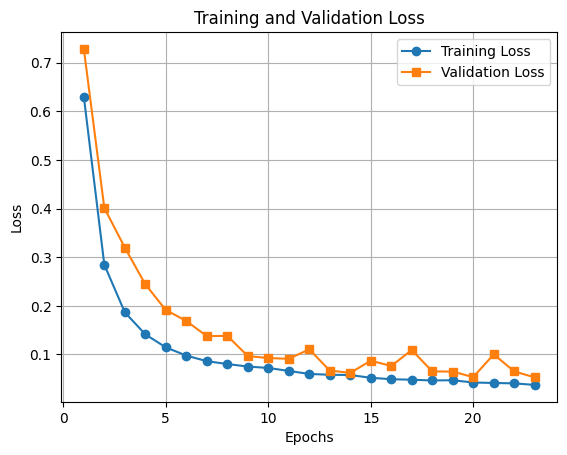

In [28]:
total_start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    # Training phase
    model.train()
    running_train_loss = 0.0
    train_batches = 0

    print(f'Epoch {epoch+1}/{num_epochs} [Train]')
    for batch in train_loader:
        inputs, _ = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_batches += 1

    # Calculate average training loss for this epoch
    epoch_train_loss = running_train_loss / train_batches
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    val_batches = 0

    with torch.no_grad():  # No gradients needed for validation
        print(f'Epoch {epoch+1}/{num_epochs} [Valid]')
        for batch in val_loader:
            inputs, _ = batch
            outputs = model(inputs)
            val_loss = criterion(outputs, inputs)

            running_val_loss += val_loss.item()
            val_batches += 1

    # Calculate average validation loss for this epoch
    epoch_val_loss = running_val_loss / val_batches
    val_losses.append(epoch_val_loss)
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time


    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Time: {epoch_duration:.2f} sec')


    # Update the plot after each epoch
    plt.clf()
    plt.plot(range(1, epoch+2), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epoch+2), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f'Total Training Time: {total_training_time:.2f} sec')


In [29]:
# Save the model
model_path = 'transformer_model.pth'
torch.save(model.state_dict(), model_path)

In [30]:
# Print best epoch
best_epoch = val_losses.index(min(val_losses)) + 1
print(f'Best model found at epoch {best_epoch} with validation loss: {min(val_losses):.4f}')

Best model found at epoch 23 with validation loss: 0.0528


In [31]:
# Load the model
model = TransformerModel(input_dim=input_dim, nhead=nhead, num_layers=2, dim_feedforward=128)
model.load_state_dict(torch.load('transformer_model.pth'))
model.eval()

TransformerModel(
  (encoder_layer): TransformerEncoderLayerCustom(
    (self_attn): MultiHeadAttention(
      (w_q): Linear(in_features=9, out_features=9, bias=True)
      (w_k): Linear(in_features=9, out_features=9, bias=True)
      (w_v): Linear(in_features=9, out_features=9, bias=True)
      (w_o): Linear(in_features=9, out_features=9, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (linear_net): PositionwiseFeedForward(
      (linear1): Linear(in_features=9, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=9, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): ReLU()
    )
    (norm1): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoderCustom(
    (layers): ModuleList(
      (0-1): 2 x TransformerEnco

In [32]:
# Evaluate on the test set
test_loader = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=32, shuffle=False)
anomalies = []
reconstructed_data = []

# Batch loss calculation
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        reconstructed_data.append(outputs.numpy())
        # Compute individual losses for each data point in the batch
        batch_losses = nn.functional.mse_loss(outputs, inputs, reduction='none')
        batch_losses = batch_losses.mean(dim=1)  # Average loss over each feature
        anomalies.extend(batch_losses.cpu().numpy())  # Append individual losses


In [33]:
# Convert anomalies to a numpy array for analysis
anomalies = np.array(anomalies)
reconstructed_data = np.vstack(reconstructed_data)

In [34]:
anomalies.shape, reconstructed_data.shape

((1470,), (1470, 9))

In [35]:
def plot_reconstruction_for_grid_id(grid_id, original_data, reconstructed_data, timestamps):
    fig, axs = plt.subplots(5, 1, figsize=(14, 20))
    columns = ['smsIn', 'smsOut', 'callIn', 'callOut', 'internet']

    grid_mask = test_grid_ids == grid_id
    for i, column in enumerate(columns):
        indices = [j for j, x in enumerate(grid_mask) if x]
        axs[i].plot([timestamps[j] for j in indices], original_data[grid_mask, i], label='Original')
        axs[i].plot([timestamps[j] for j in indices], reconstructed_data[grid_mask, i], label='Reconstructed')


        axs[i].set_title(f'{column} - Original vs Reconstructed for GridID {grid_id}', fontsize=20)


        axs[i].set_xlabel("Time", fontsize=20)
        axs[i].set_ylabel(column, fontsize=20)


        axs[i].legend(fontsize=14)

        axs[i].tick_params(axis='both', labelsize=20)

    plt.tight_layout()
    plt.show()

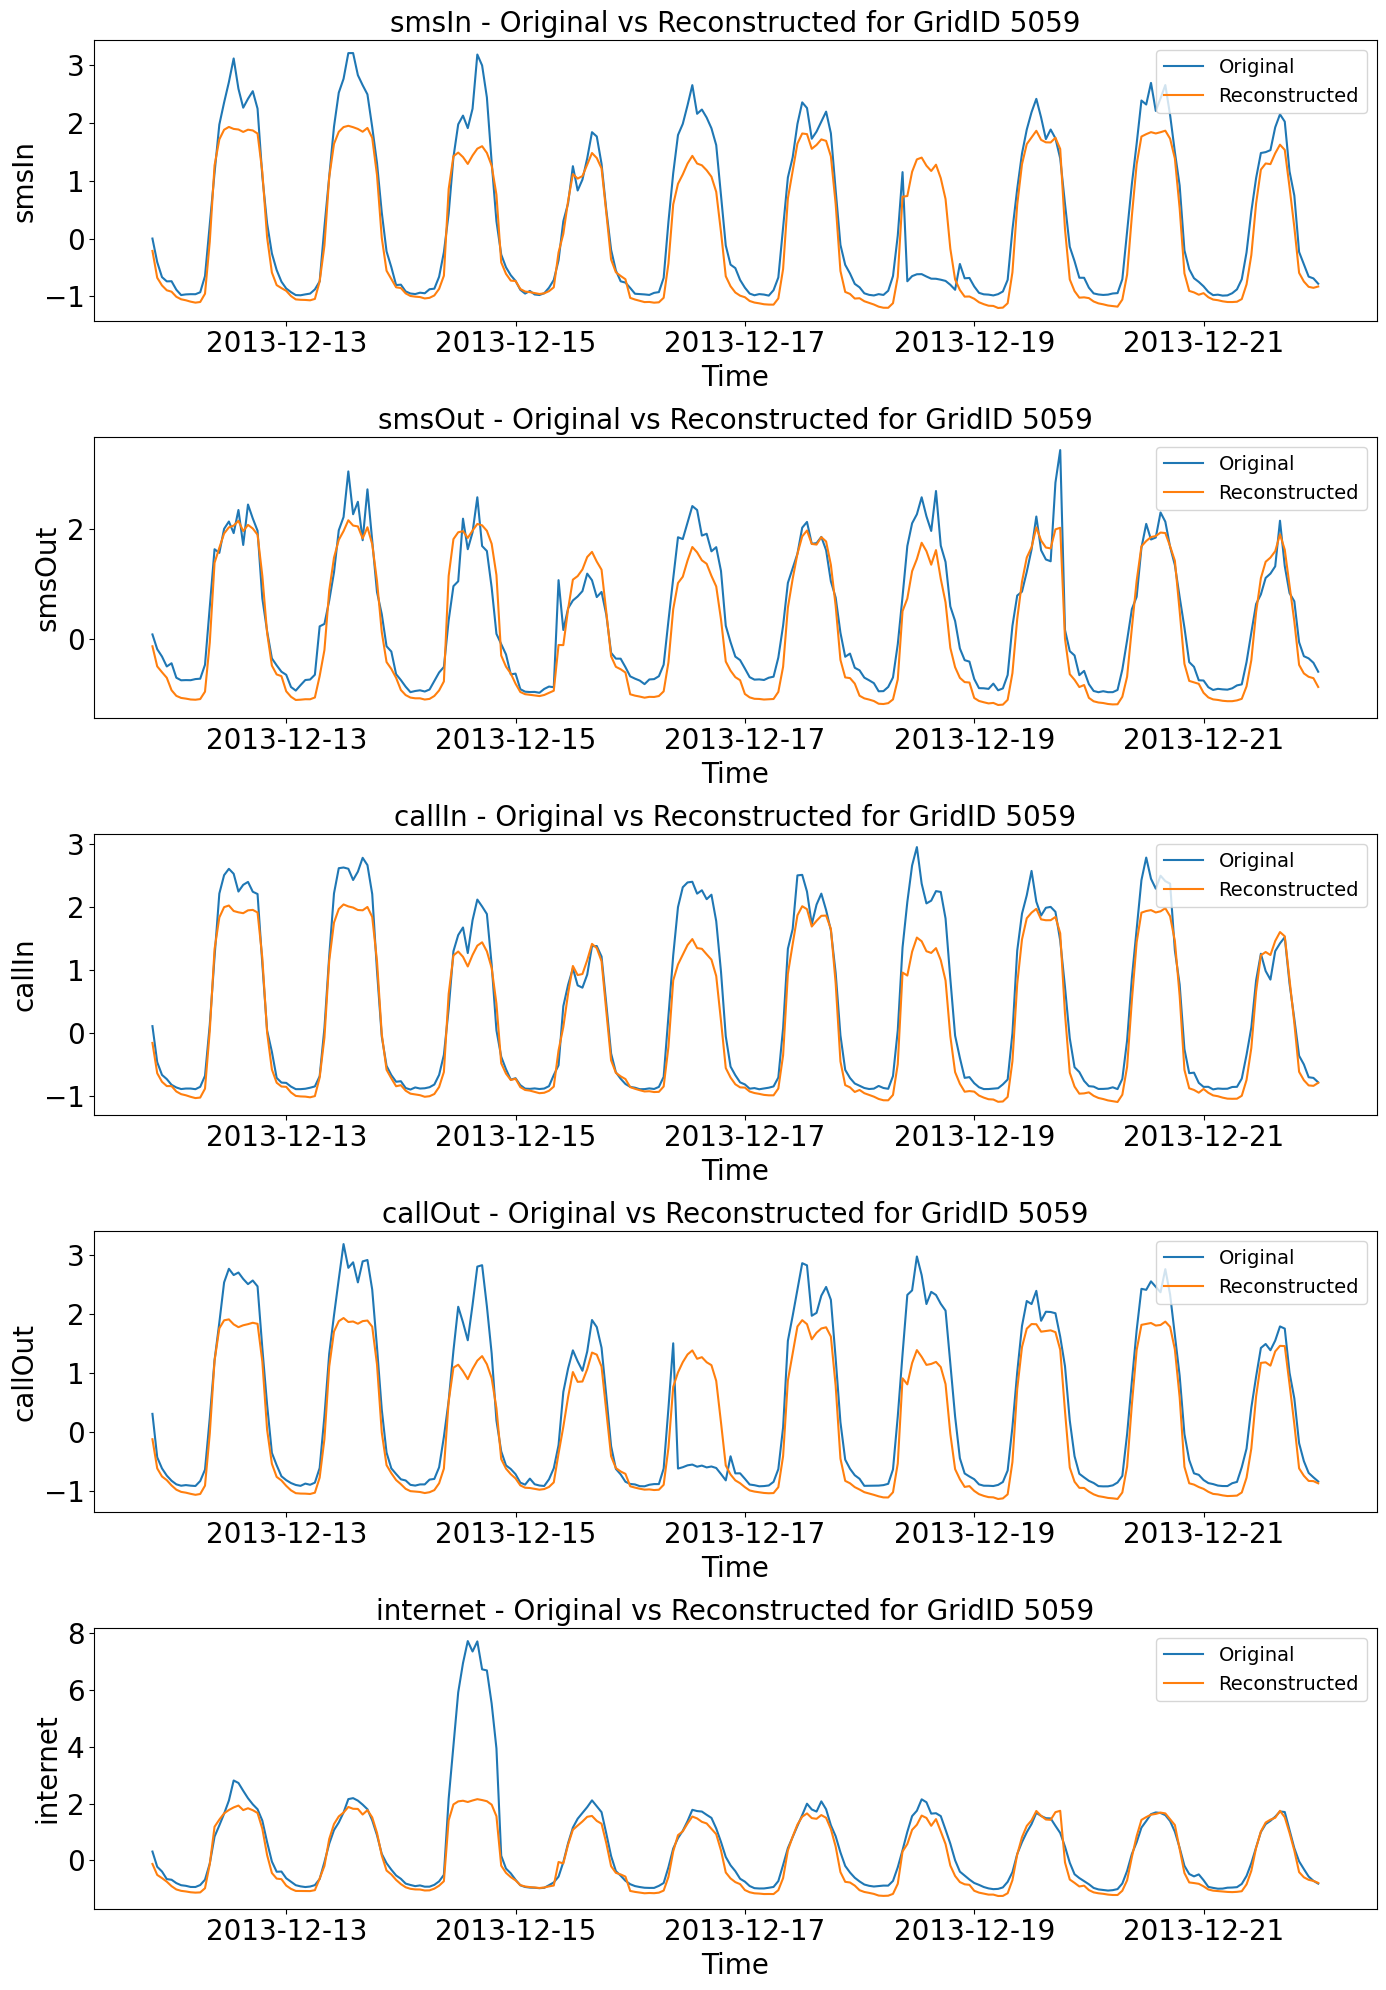

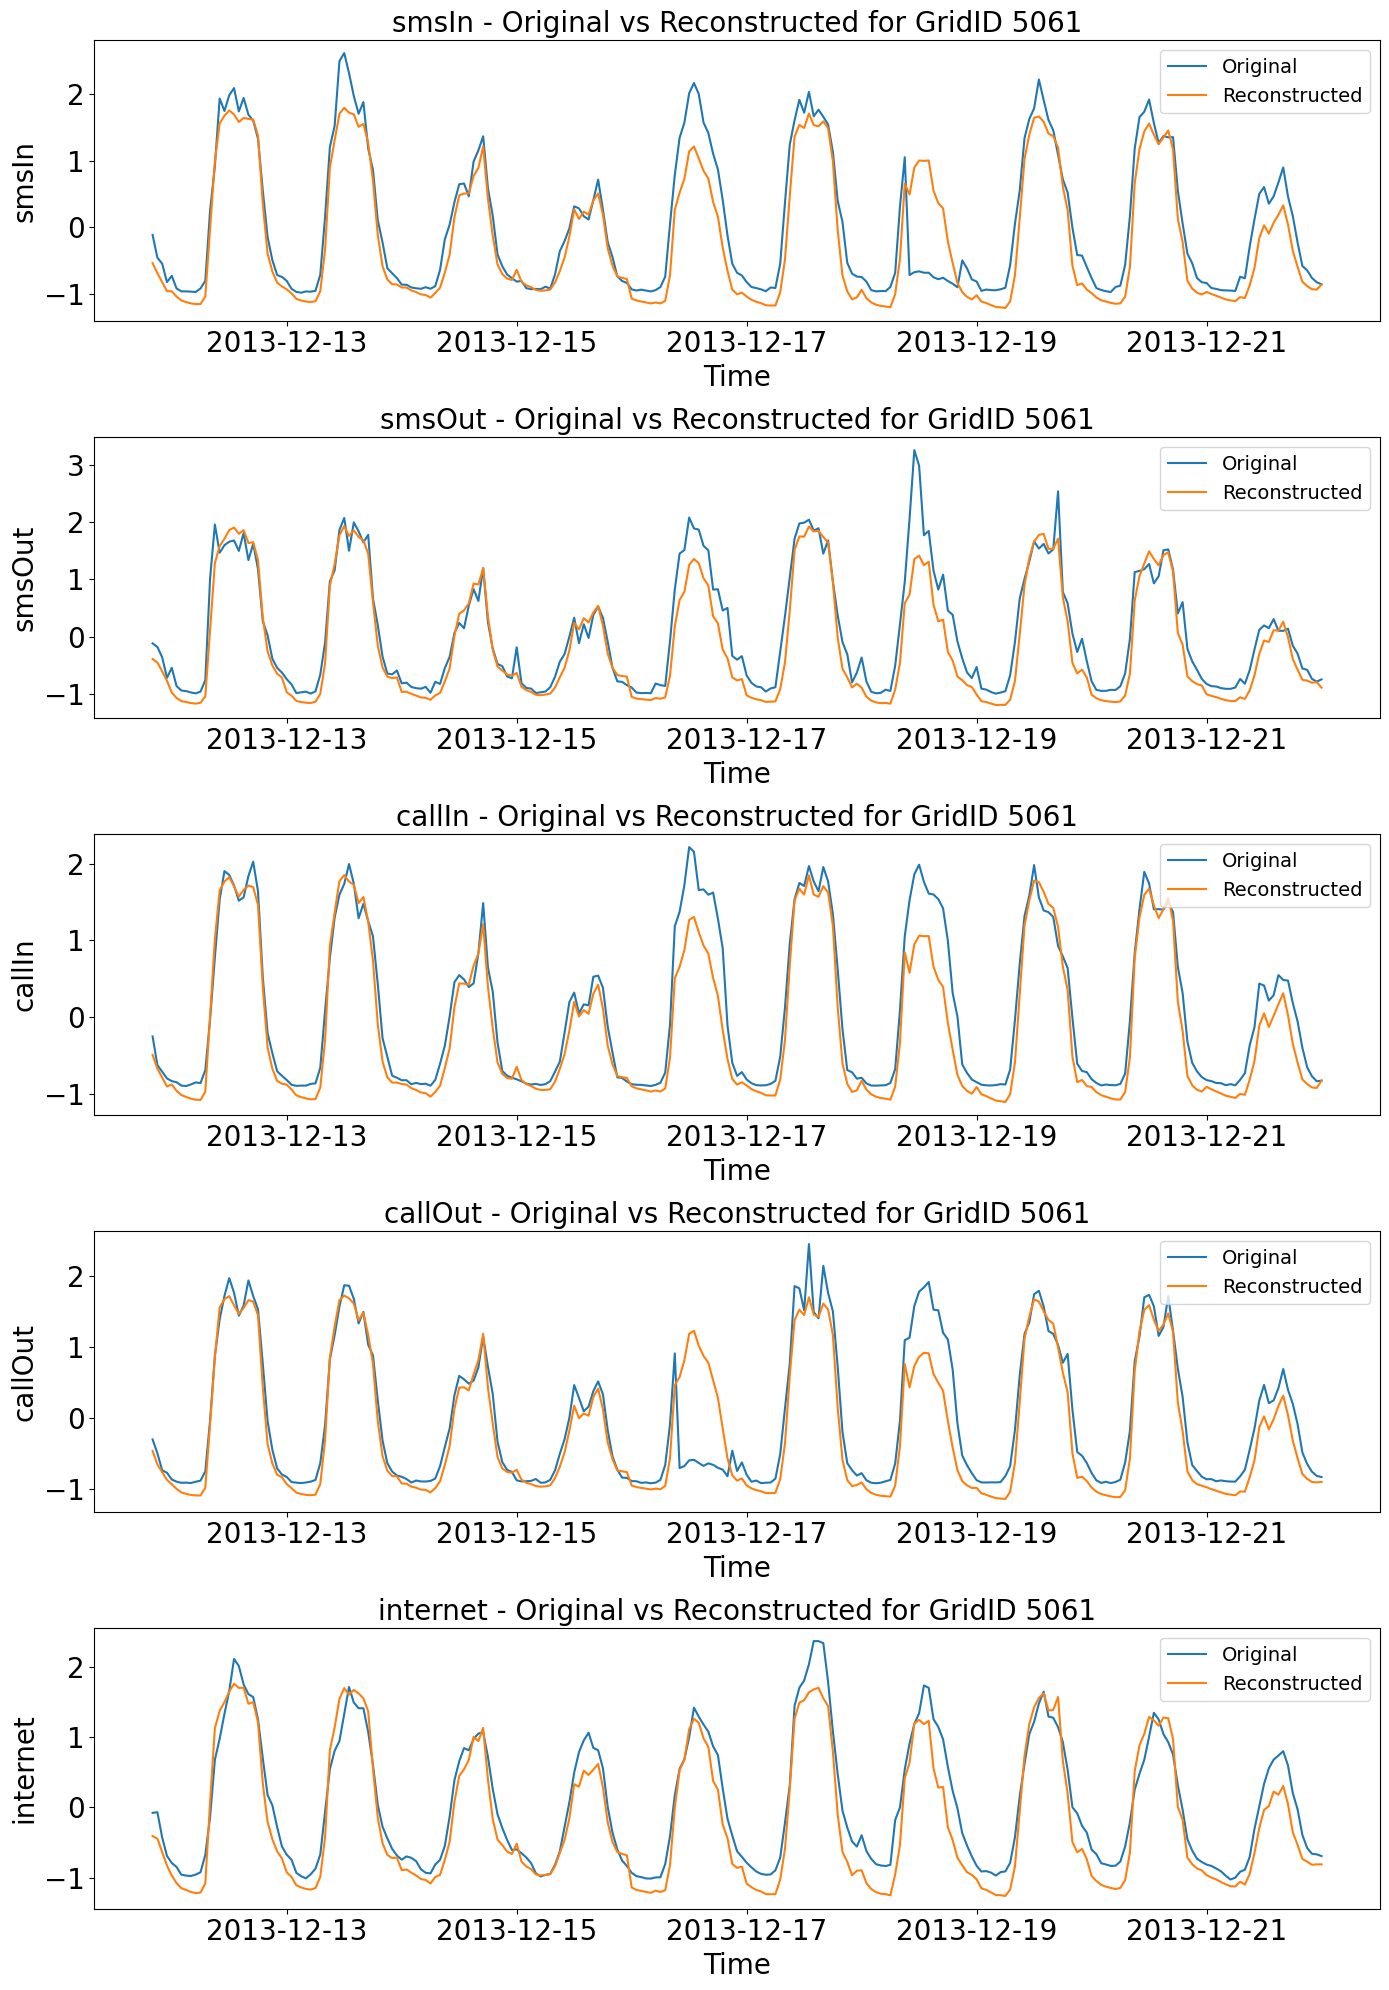

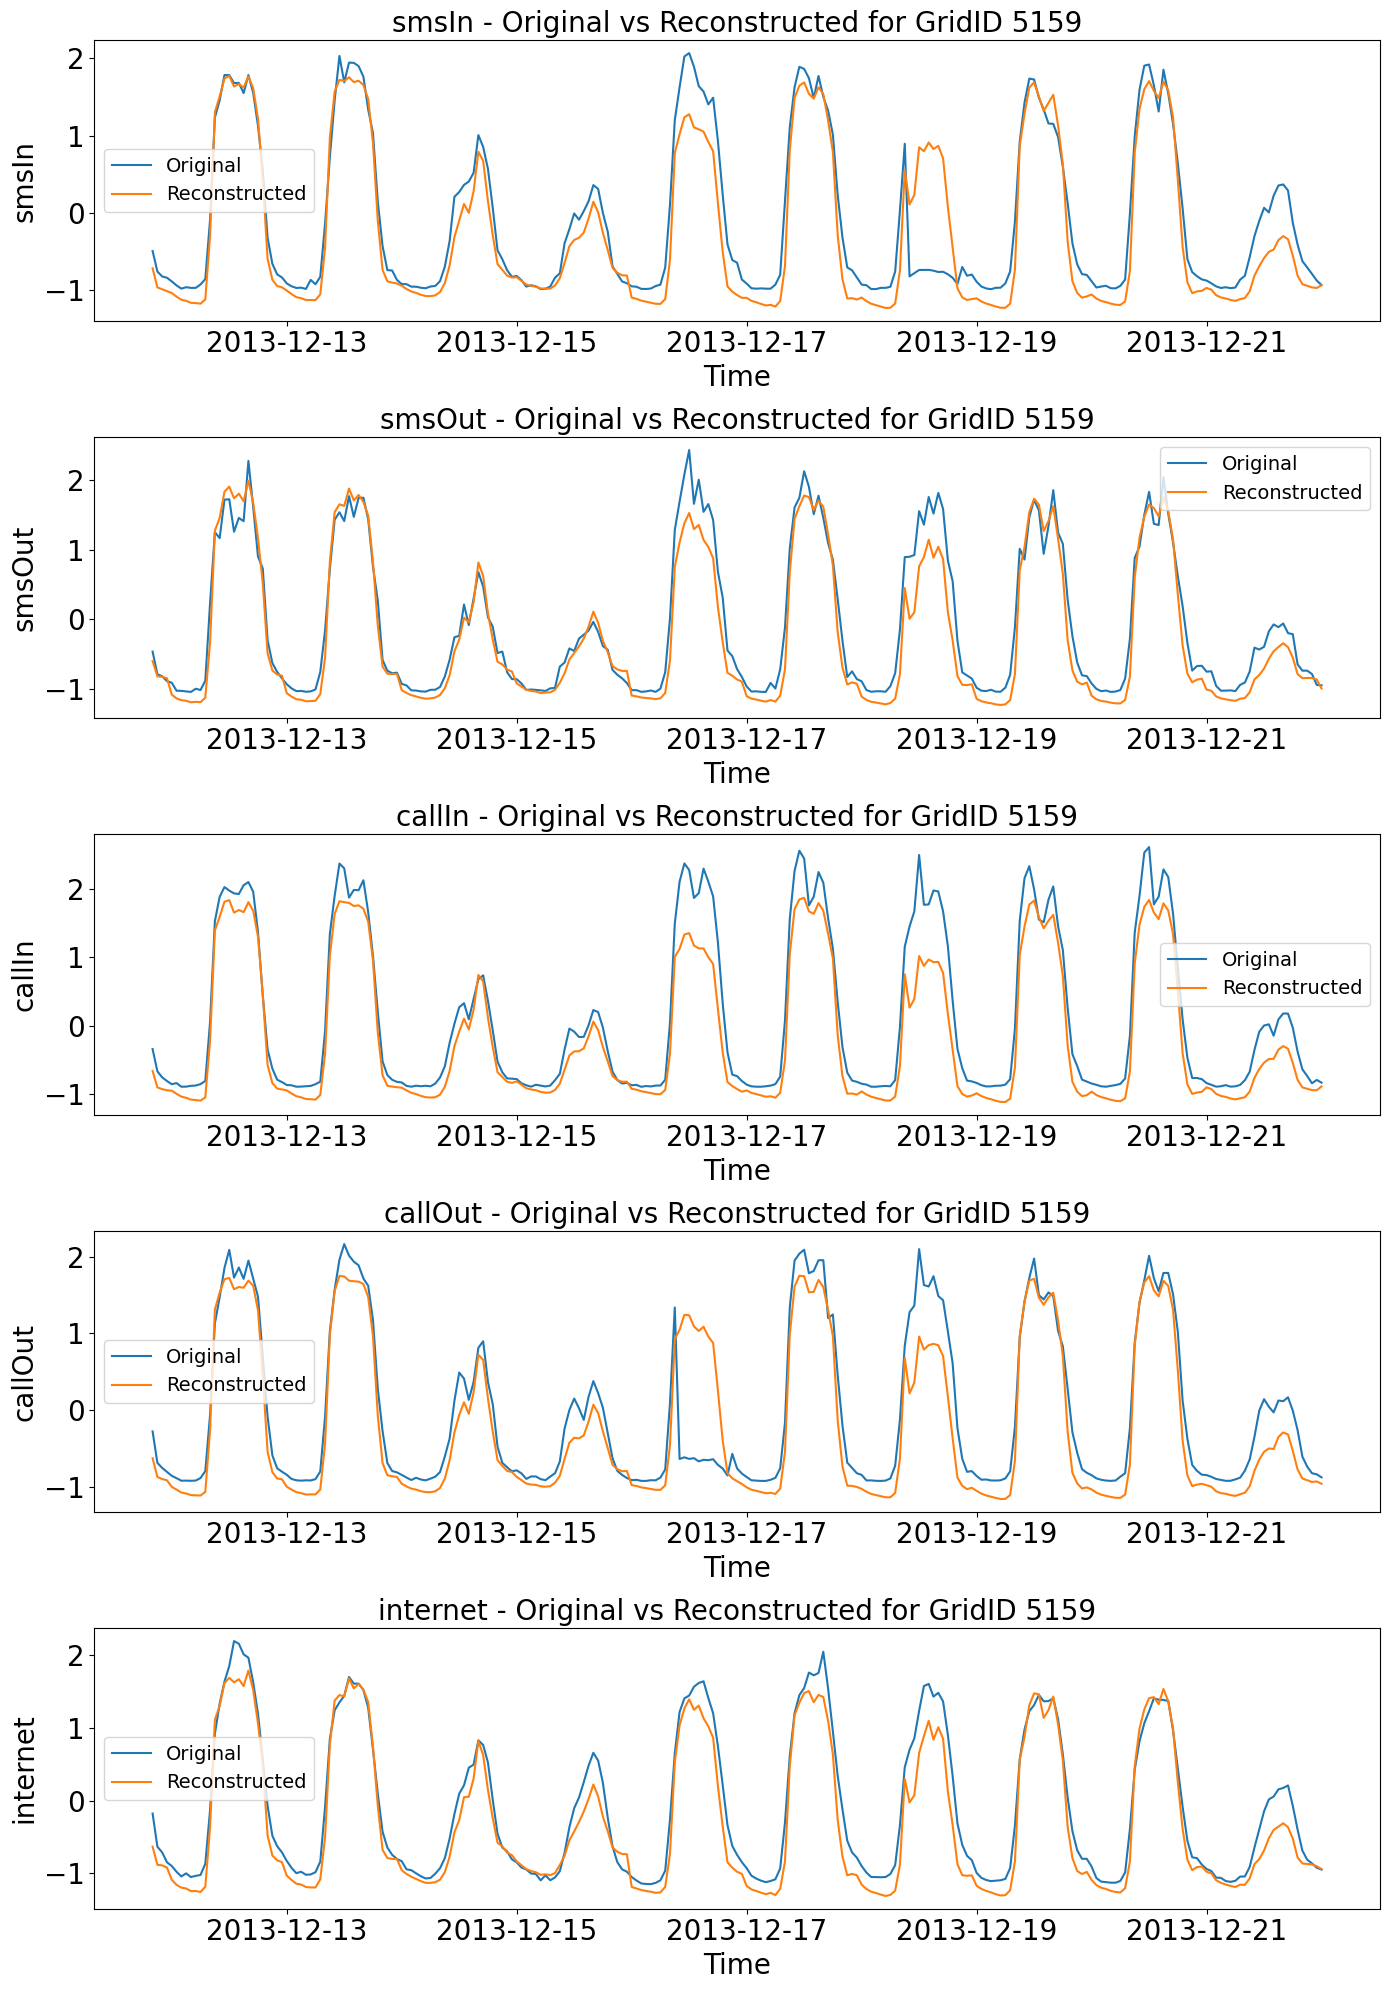

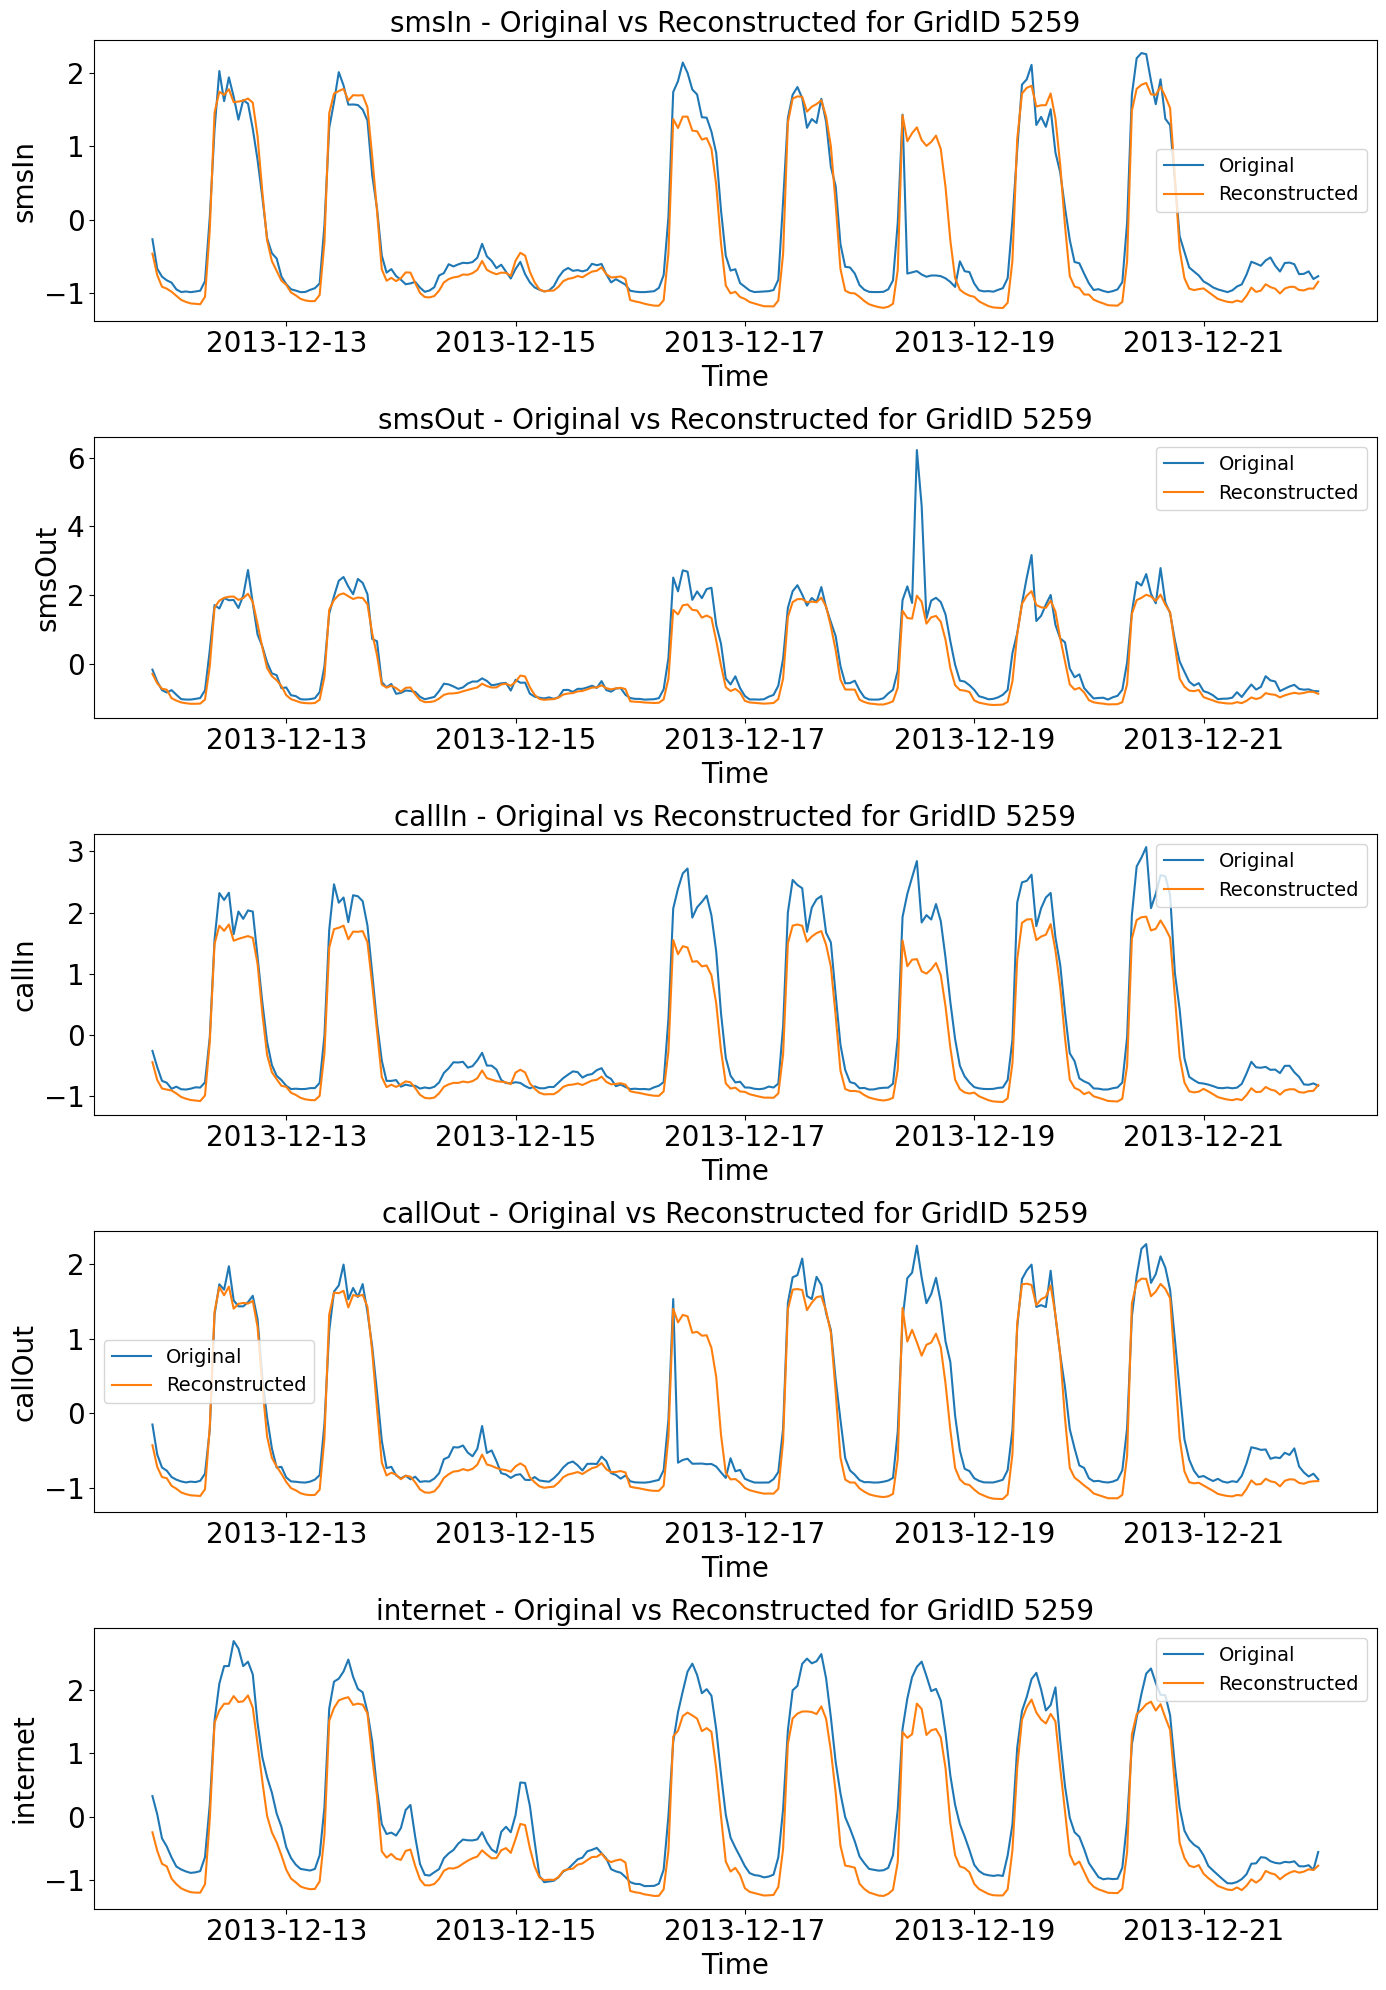

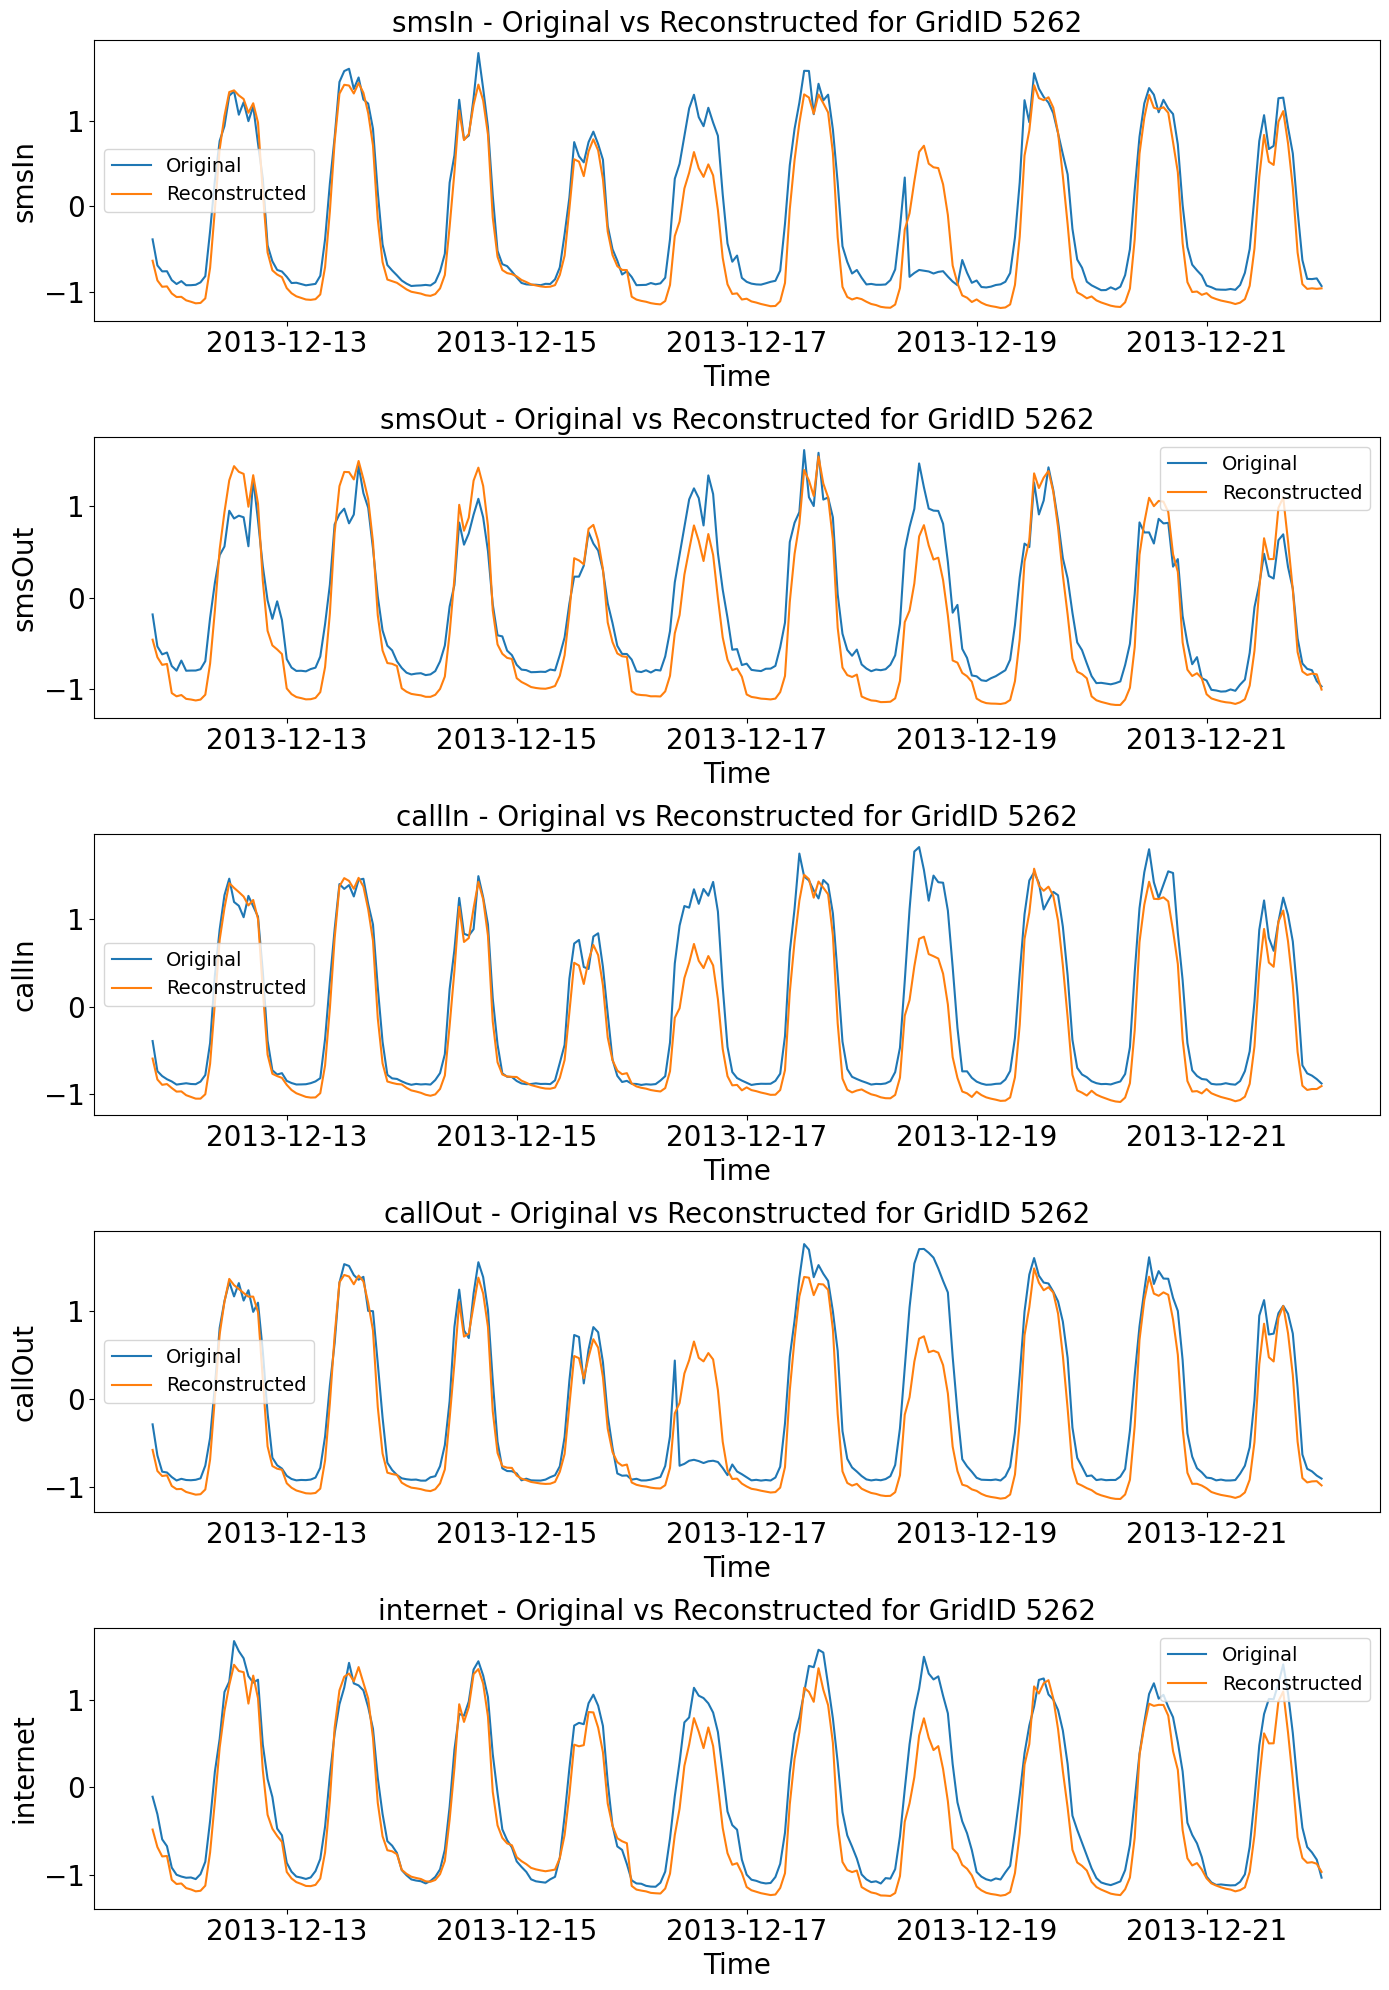

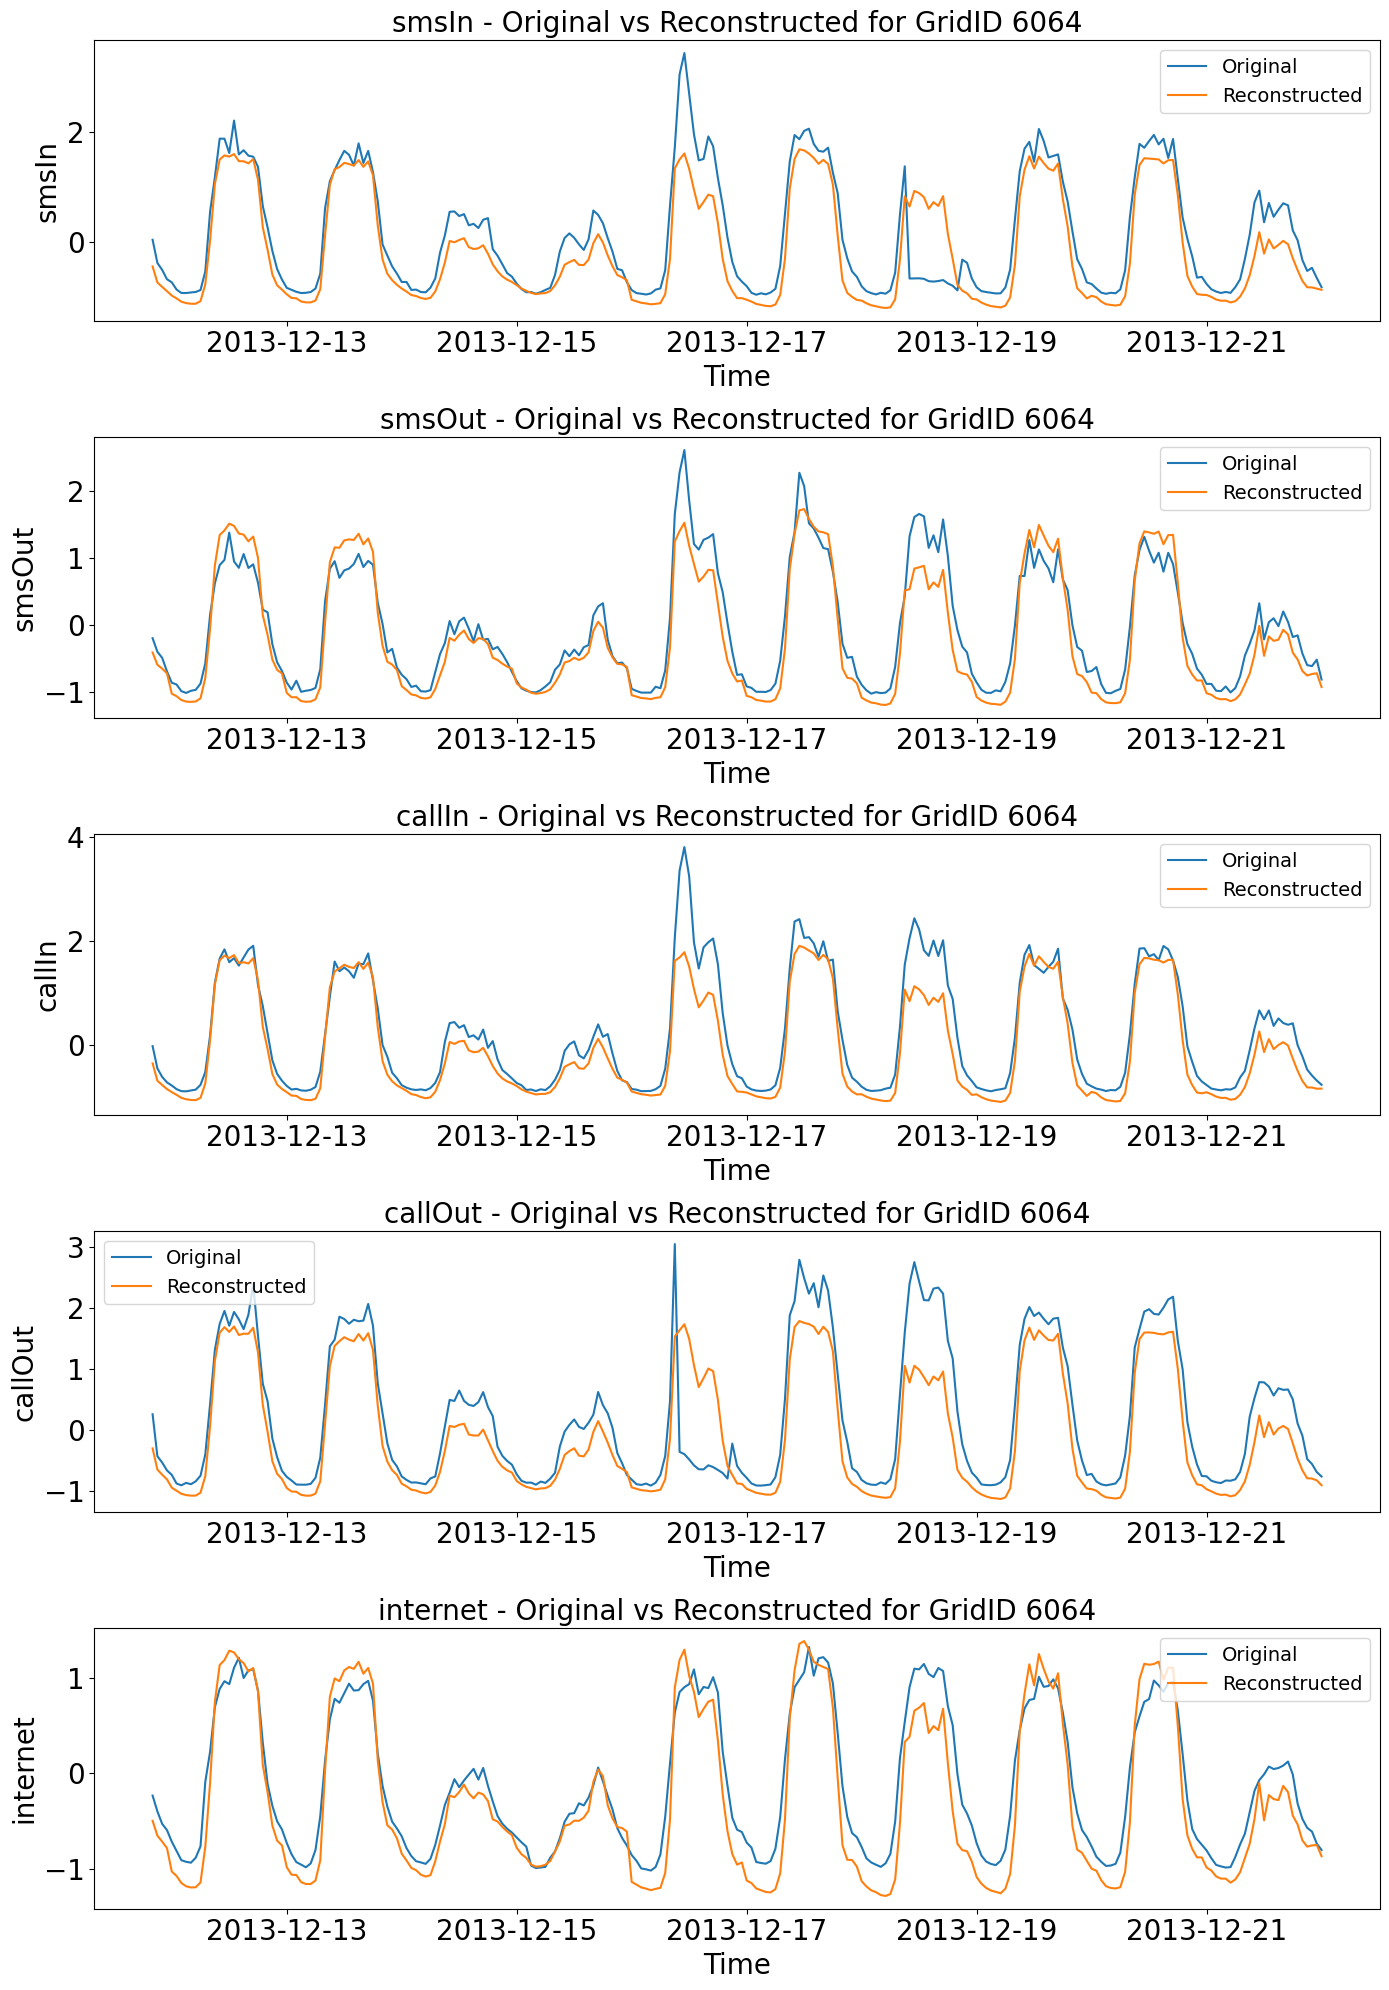

In [36]:
# Plot original vs reconstructed data for each unique gridID in the test set
unique_grid_ids = np.unique(test_grid_ids)
for grid_id in unique_grid_ids:
    plot_reconstruction_for_grid_id(grid_id, test_tensor.numpy(), reconstructed_data, test_timestamps)

In [37]:
# Saving the entire reconstructed data as dataset in case we need it for some metrics such as cm, acc and f1
reconstructed_df = pd.DataFrame(reconstructed_data, index=test_timestamps, columns=test_data.columns)
reconstructed_df.to_csv('reconstructed_dataset.csv')

In [38]:
# Saving the entire reconstructed data as dataset  in case we need it for some metrics such as cm, acc and f1
reconstructed_df = pd.DataFrame(reconstructed_data, index=test_timestamps, columns=test_data.columns)

# Add the anomaly scores to the DataFrame
reconstructed_df['anomaly_score'] = anomalies

# Mark data points as anomalies based on a threshold
anomaly_threshold = np.percentile(anomalies, 80) # Adjust according to the threshold chosen by you
reconstructed_df['anomaly'] = (reconstructed_df['anomaly_score'] > anomaly_threshold).astype(int)

reconstructed_df.to_csv('reconstructed_dataset_with_anomalies.csv')

In [39]:
def plot_anomalies(test_timestamps, anomalies, anomaly_threshold,anomaly_timestamps, anomaly_grid_ids, anomaly_indices):
  # Visualize anomalies
  plt.figure(figsize=(14, 7))
  plt.plot(test_timestamps, anomalies, label='Anomaly Score')
  plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
  plt.scatter(anomaly_timestamps, anomalies[anomaly_indices], color='red', label='Anomalies')
  plt.xlabel('Time')
  plt.ylabel('Anomaly Score')
  plt.title('Anomaly Detection in Mobile Network Data')
  plt.legend()
  plt.show()

In [40]:
def identify_anomalies(anomalies, test_timestamps, test_grid_ids, test_data):
  anomaly_threshold = np.percentile(anomalies, 80)
  anomaly_indices = np.where(anomalies > anomaly_threshold)[0]
  # Convert anomaly_indices to a list of integers
  anomaly_indices = anomaly_indices.astype(int).tolist()
  anomaly_timestamps = [test_timestamps[i] for i in anomaly_indices]
  anomaly_grid_ids = test_grid_ids[anomaly_indices]
  anomaly_features = test_data.iloc[anomaly_indices].values
  return anomaly_timestamps, anomaly_grid_ids, anomaly_threshold, anomaly_indices, anomaly_features

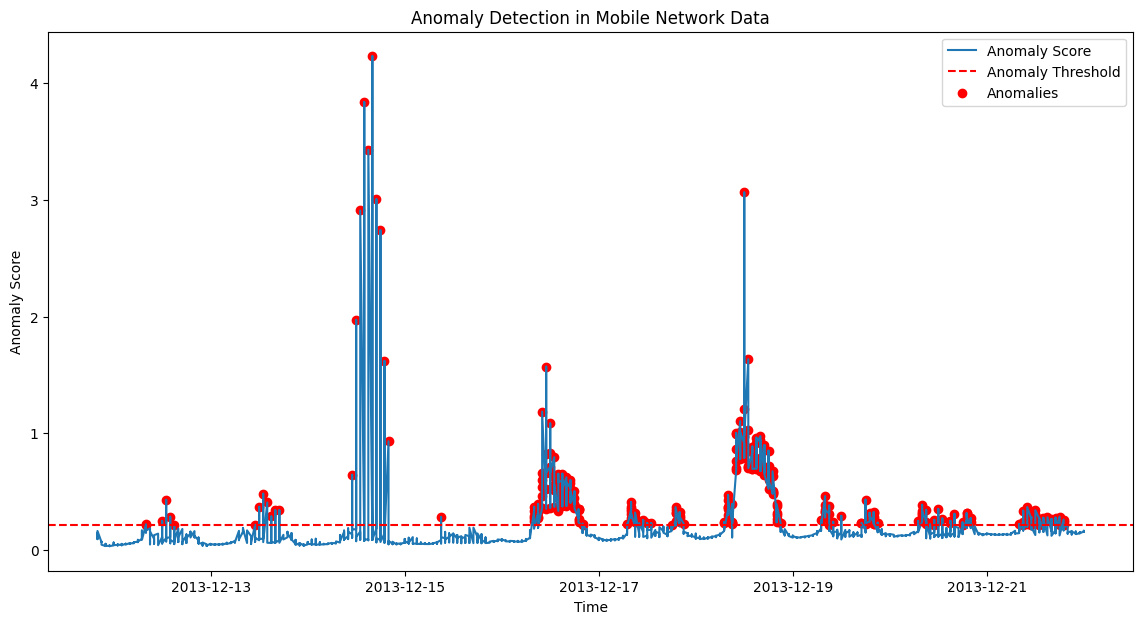

In [41]:
anomaly_timestamps, anomaly_grid_ids, anomaly_threshold, anomaly_indices,anomaly_features = identify_anomalies(anomalies, test_timestamps, test_grid_ids, test_data)
#
anomalous_data_model = pd.DataFrame()
anomalous_data_model['anomaly_timestamp'] = anomaly_timestamps
anomalous_data_model['anomaly_timestamp'] = pd.to_datetime(anomalous_data_model['anomaly_timestamp'], format="%Y-%m-%d %H:%M:%S")
anomalous_data_model['anomaly_grid'] = anomaly_grid_ids
anomalous_data_model.to_csv('anomalies_model.csv', index=False)
#
plot_anomalies(test_timestamps, anomalies, anomaly_threshold, anomaly_timestamps, anomaly_grid_ids, anomaly_indices)

In [42]:
#Drop all anomaly columns equal to 0
test_abnormal = pd.read_csv("test_dataset_abnormal.csv")
test_abnormal = test_abnormal[test_abnormal["anomaly"] != 0]
test_abnormal.to_csv("injected_anomalies.csv", index=False)

In [43]:
#anomalous_data_model => anomalies identified by the model     (anomalies_model)
#test_abnormal => injected anomalies (true anomalies)          (filtered_test_dataset_abnormal)

# Convert 'Timestamp' and 'startTime' using automatic format inference
anomalous_data_model['anomaly_timestamp'] = pd.to_datetime(anomalous_data_model['anomaly_timestamp'], errors='coerce')
test_abnormal['startTime'] = pd.to_datetime(test_abnormal['startTime'], errors='coerce')

In [44]:
anomalous_data_model.shape

(294, 2)

In [45]:
merged_df = pd.merge(anomalous_data_model, test_abnormal, left_on=['anomaly_timestamp', 'anomaly_grid'], right_on=['startTime', 'gridID'], how='inner')

In [46]:
merged_df

anomaly_timestamp  anomaly_grid  gridID           startTime  \
0   2013-12-14 11:00:00          5059    5059 2013-12-14 11:00:00   
1   2013-12-14 12:00:00          5059    5059 2013-12-14 12:00:00   
2   2013-12-14 13:00:00          5059    5059 2013-12-14 13:00:00   
3   2013-12-14 14:00:00          5059    5059 2013-12-14 14:00:00   
4   2013-12-14 15:00:00          5059    5059 2013-12-14 15:00:00   
..                  ...           ...     ...                 ...   
133 2013-12-18 20:00:00          5159    5159 2013-12-18 20:00:00   
134 2013-12-18 20:00:00          5059    5059 2013-12-18 20:00:00   
135 2013-12-18 20:00:00          5262    5262 2013-12-18 20:00:00   
136 2013-12-18 20:00:00          5061    5061 2013-12-18 20:00:00   
137 2013-12-18 20:00:00          6064    6064 2013-12-18 20:00:00   

           smsIn      smsOut       callIn      callOut      internet  anomaly  
0    1479.136379  556.760997   941.248122  1068.046517  28787.036181        1  
1    1829.513298  581.343243  1050.937450  1413.252409  38738.167569        1  
2    1922.505204  896.034323  1102.463478  1290.052171  44261.699773        1  
3    1789.207042  742.470167   928.660964  1149.592928  48423.608645        1  
4    1995.964117  827.534748  1151.933630  1428.129267  46455.539809        1  
..           ...         ...          ...          ...           ...      ...  
133    41.315886  203.592291   237.206312   318.660442   5310.634604        2  
134    64.205901  381.568421   366.872152   550.024098   7004.802736        2  
135    41.573927  266.296170   279.372861   359.767609   6056.058536        2  
136    56.204301  265.853730   387.007308   391.540026   6905.431302        2  
137    61.005712  265.997562   442.684371   565.032494   6936.547819        2  

[138 rows x 10 columns]

In [47]:
#Anomalies found
print(f"{merged_df.shape[0]} / {test_abnormal.shape[0]}")

138 / 143
